# Table of Contents

### Stage 1 - Prep the data
* [Step 1.) Import necessary libraries and adjust display settings](#Step1)
* [Step 2.) Create yearly team standing dataframe by combining files](#Step5)
        - Load in raw data
        - Filter year range
        - Address team name changes (e.g. Charlotte Bobcats -> Hornets) using replacement dictionary
        - Derive columns like total wins, total losses, and win % using available data       
* [Step 3.) Create yearly player performance dataframe by combining files](#Step2)
        - Load in raw data
        - Filter year range
        - Drop duplicate records from when players change team 
        - Clean player names
* [Step 4.) Create draft history dataframe](#Step3)
        - Load in raw data
        - Filter year range
        - Identify rare issues where primary key (player name) are identical
        - Utilize Levenshtein match scores to match player name keys between draft dataframe and yearly stats dataframe
        - Replace player names using dictionary created above
* [Step 5.) Create draft combine stats dataframe](#Step6)
        - Load in raw data
        - Filter year range
        - Replace player names using dictionary created in previous step so they match other player name keys        
  
* [Step 6.) Create 2023-2024 Player Salary dataframe](#Step4)
        - Load in raw data
        - Clean data
* [Step 7.) Create 2023-2024 Vegas Team Standing Predictions dataframe](#Step7)
        - Load in raw data
* [Step 8.) Create 2023-2024 Team Standing dataframe](#Step8)
        - Load in raw data
        - Derive new columns by parsing overall record field into total wins, total losses, win %
       
        
### Stage 2 - Analyze the Data and Answer Questions

* [Question 1.) Which Player in the last 10 years had the highest WS/48 in one season (min of 60 games played)? In which year?](#Question1)
* [Question 2.) Which player in the last 10 years played the most minutes in a single season after playing in all 82 games? In which year?](#Question2)
* [Question 3.) FUTURE WORK](#Question3)
* [Question 4.) Which draft pick positions provide the best value?](#Question4)
* [Question 5.) Biggest number one pick draft bust from 2003-2018? How about for each overall draft position?](#Question5)
* [Question 6.) Which player represents the average player for each pick position?](#Question6)
* [Question 7.) For players that have played at least 10 years, on average which age did they peak?](#Question7)
* [Question 8.) Which players were most underpaid and overpaid players in 2023-2024?](#Question8)
* [Question 9.) Which teams are most underperforming and overperforming compared to Vegas predictions? How good is Vegas?](#Question9)
* [Question 10.) Which team has had the best regular season in the last 10 years? In which year? How about worst? In which year?](#Question10)
* [Question 11.) Which team has had the biggest bounce back? In which year? How about falloff? In which year?](#Question11)
* [Question 12.) Which team has had the biggest mid-season bounce back? In which year? How about falloff? In which year?](#Question12)
* [Question 13.) Is home team advantage real? Which teams most benefit? Which don't?](#Question13)

### Stage 3 - Dynamically Export dataframes of interest created in Stages 1 and 2 to their own Excel worksheets within the source Excel Workbook
* [Part 1.) Create the appropriately named worksheets within the source Excel Workbook](#Stage3Step1)
* [Part 2.) Write the dataframes and their data to the newly created worksheets](#Stage3Step1)

### Stage 4 - Regression Analysis on Combine Stats vs. Actual Player Performance 
### Stage 5 - Deep dive into player age vs performance across eras

# Stage 1 - Prep the Data

## Import necessary libraries and adjust display settings <a class="anchor" id="Step1"></a>

In [609]:
import os as os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import itertools
from openpyxl import load_workbook
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2f}'.format
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt 
#pd.options.display.float_format = "{:,.2f}".format

# Create list of dataframes and dataframe names
list_of_dataframes = []
list_of_dataframe_names = []

## Create a singular dataframe containing team stats since 2013. <a class="anchor" id="Step5"></a>

In [573]:
yearly_team_standings_folder_path = f'{os.getcwd()}\\Yearly Team Standings'

master_df_list = []

cumulative_row_counter = 0

for file_name in os.listdir(yearly_team_standings_folder_path):
    
    # Assign season value
    year = file_name.split(' ')[0]
    
    # Create dataframe name
    dataframe_name = f'_{file_name.split(".")[0].lower().replace(" ","_")}_df'
    
    # Store dataframe globally with specified name
    globals()[dataframe_name] = pd.read_csv(f'{yearly_team_standings_folder_path}\\{file_name}',header=1)
    
    # Derive Win Columns, Loss Column, and Win/Loss Percentage Column
    def win_splitter(overall_record):
        wins = int(overall_record.split('-')[0])
        return wins

    def loss_splitter(overall_record):
        losses = int(overall_record.split('-')[1])
        return losses

    globals()[dataframe_name]['Team Wins'] = globals()[dataframe_name]['Overall'].apply(win_splitter)
    globals()[dataframe_name]['Team Losses'] = globals()[dataframe_name]['Overall'].apply(loss_splitter)
    globals()[dataframe_name]['Win Loss %'] = globals()[dataframe_name]['Team Wins']/(globals()[dataframe_name]['Team Wins'] + globals()[dataframe_name]['Team Losses'])
    
    # Derive Home Wins and Losses
    globals()[dataframe_name]['Home Game Wins'] = globals()[dataframe_name]['Home'].apply(win_splitter)
    globals()[dataframe_name]['Home Game Losses'] = globals()[dataframe_name]['Home'].apply(loss_splitter)
    globals()[dataframe_name]['Home Game Win %'] = globals()[dataframe_name]['Home Game Wins'] / (globals()[dataframe_name]['Home Game Losses'] + globals()[dataframe_name]['Home Game Wins'])
    
    # Derive Away Wins and Losses
    globals()[dataframe_name]['Away Game Wins'] = globals()[dataframe_name]['Road'].apply(win_splitter)
    globals()[dataframe_name]['Away Game Losses'] = globals()[dataframe_name]['Road'].apply(loss_splitter)
    globals()[dataframe_name]['Away Game Win %'] = globals()[dataframe_name]['Away Game Wins'] / (globals()[dataframe_name]['Away Game Losses'] + globals()[dataframe_name]['Away Game Wins'])
    
    # Derive Difference Between Home And Away W/L
    globals()[dataframe_name]['Difference of Home Game Win % and Away Game Win %'] = globals()[dataframe_name]['Home Game Win %'] - globals()[dataframe_name]['Away Game Win %']
    
    # Derive Before All-Star Break and Post All-Star Break 
    globals()[dataframe_name]['Pre All-Star Game Wins'] = globals()[dataframe_name]['Pre'].apply(win_splitter)
    globals()[dataframe_name]['Pre All-Star Game Losses'] = globals()[dataframe_name]['Pre'].apply(loss_splitter)
    globals()[dataframe_name]['Pre All-Star Win %'] = globals()[dataframe_name]['Pre All-Star Game Wins'] / (globals()[dataframe_name]['Pre All-Star Game Losses'] + globals()[dataframe_name]['Pre All-Star Game Wins'])

    globals()[dataframe_name]['Post All-Star Game Wins'] = globals()[dataframe_name]['Post'].apply(win_splitter)
    globals()[dataframe_name]['Post All-Star Game Losses'] = globals()[dataframe_name]['Post'].apply(loss_splitter)      
    globals()[dataframe_name]['Post All-Star Win %'] = globals()[dataframe_name]['Post All-Star Game Wins'] / (globals()[dataframe_name]['Post All-Star Game Losses'] + globals()[dataframe_name]['Post All-Star Game Wins'])
    
    # Derive Difference Between Pre and Post All Star
    # Derive Difference Between Home And Away W/L
    globals()[dataframe_name]['Difference of Post All-Star Win % and Pre All-Star Win %'] = globals()[dataframe_name]['Post All-Star Win %'] - globals()[dataframe_name]['Pre All-Star Win %']
    
    # Filter on only columns of interest
    globals()[dataframe_name] = globals()[dataframe_name][['Rk','Team','Overall','Team Wins','Team Losses','Win Loss %','Home Game Wins','Home Game Losses','Home Game Win %','Away Game Wins','Away Game Losses','Away Game Win %','Difference of Home Game Win % and Away Game Win %','Pre All-Star Game Wins','Pre All-Star Game Losses','Pre All-Star Win %','Post All-Star Game Wins','Post All-Star Game Losses','Post All-Star Win %','Difference of Post All-Star Win % and Pre All-Star Win %']]
    
    # Add a Year Column and assign to year
    globals()[dataframe_name]['Year'] = int(year)
    
    # Append to master_df_list
    master_df_list.append(globals()[dataframe_name]) 
    
    # Cumulative_row_counter
    cumulative_row_counter = cumulative_row_counter + len(globals()[dataframe_name])

master_df_list[2].head(5)

,Rk,Team,Overall,Team Wins,Team Losses,Win Loss %,Home Game Wins,Home Game Losses,Home Game Win %,Away Game Wins,...,Away Game Win %,Difference of Home Game Win % and Away Game Win %,Pre All-Star Game Wins,Pre All-Star Game Losses,Pre All-Star Win %,Post All-Star Game Wins,Post All-Star Game Losses,Post All-Star Win %,Difference of Post All-Star Win % and Pre All-Star Win %,Year
0,1,Golden State Warriors,67-15,67,15,0.8171,39,2,0.9512,28,...,0.6829,0.2683,42,9,0.8235,25,6,0.8065,-0.0171,2014
1,2,Atlanta Hawks,60-22,60,22,0.7317,35,6,0.8537,25,...,0.6098,0.2439,43,11,0.7963,17,11,0.6071,-0.1892,2014
2,3,Houston Rockets,56-26,56,26,0.6829,30,11,0.7317,26,...,0.6341,0.0976,36,17,0.6792,20,9,0.6897,0.0104,2014
3,4,Los Angeles Clippers,56-26,56,26,0.6829,30,11,0.7317,26,...,0.6341,0.0976,35,19,0.6481,21,7,0.7500,0.1019,2014
4,5,Memphis Grizzlies,55-27,55,27,0.6707,31,10,0.7561,24,...,0.5854,0.1707,39,14,0.7358,16,13,0.5517,-0.1841,2014


In [574]:
# Concat all dataframes into one
yearly_team_standings_df = pd.concat(master_df_list)

# Verify that total record count of master dataframe matches the cumulative record count of the original dataframes
if len(yearly_team_standings_df)!=cumulative_row_counter:
    raise Exception('Record count of master dataframe does not match cumulative count of component dataframes')
    
# Reset indices
yearly_team_standings_df.reset_index(drop=True,inplace=True)

yearly_team_standings_df.head(5)

,Rk,Team,Overall,Team Wins,Team Losses,Win Loss %,Home Game Wins,Home Game Losses,Home Game Win %,Away Game Wins,...,Away Game Win %,Difference of Home Game Win % and Away Game Win %,Pre All-Star Game Wins,Pre All-Star Game Losses,Pre All-Star Win %,Post All-Star Game Wins,Post All-Star Game Losses,Post All-Star Win %,Difference of Post All-Star Win % and Pre All-Star Win %,Year
0,1,Miami Heat,66-16,66,16,0.8049,37,4,0.9024,29,...,0.7073,0.1951,36,14,0.7200,30,2,0.9375,0.2175,2012
1,2,Oklahoma City Thunder,60-22,60,22,0.7317,34,7,0.8293,26,...,0.6341,0.1951,39,14,0.7358,21,8,0.7241,-0.0117,2012
2,3,San Antonio Spurs,58-24,58,24,0.7073,35,6,0.8537,23,...,0.5610,0.2927,42,12,0.7778,16,12,0.5714,-0.2063,2012
3,4,Denver Nuggets,57-25,57,25,0.6951,38,3,0.9268,19,...,0.4634,0.4634,33,21,0.6111,24,4,0.8571,0.2460,2012
4,5,Los Angeles Clippers,56-26,56,26,0.6829,32,9,0.7805,24,...,0.5854,0.1951,39,17,0.6964,17,9,0.6538,-0.0426,2012


In [575]:
# Normalize Team Names Using Dictionary
nba_team_name_dict = {'Charlotte Bobcats':'Charlotte Hornets','New Orleans Hornets':'New Orleans Pelicans'}

print(len(yearly_team_standings_df['Team'].unique()))

yearly_team_standings_df['Team'].replace(nba_team_name_dict,inplace=True)

print(len(yearly_team_standings_df['Team'].unique()))

32
30


In [576]:
# Create empty column to populate
yearly_team_standings_df['Win Change From Prior Year'] = np.nan
yearly_team_standings_df['Win % Change From Prior Year'] = np.nan

# Populate with bounce back data
years_of_interest = list(yearly_team_standings_df['Year'].unique())
list_of_nba_teams = list(yearly_team_standings_df['Team'].unique())

# Iterate through years and teams to generate bounce back data
for year in years_of_interest:
    
    if year != 2012:
    
        for team in list_of_nba_teams:

            year_before = year-1

            current_year_win_value = yearly_team_standings_df.loc[(yearly_team_standings_df['Year']==year)&(yearly_team_standings_df['Team']==team)]['Team Wins'].reset_index(drop=True)[0]

            year_before_win_value = yearly_team_standings_df.loc[(yearly_team_standings_df['Year']==year_before)&(yearly_team_standings_df['Team']==team)]['Team Wins'].reset_index(drop=True)[0]

            current_year_percent_win_value = yearly_team_standings_df.loc[(yearly_team_standings_df['Year']==year)&(yearly_team_standings_df['Team']==team)]['Win Loss %'].reset_index(drop=True)[0]

            year_before_percent_win_value = yearly_team_standings_df.loc[(yearly_team_standings_df['Year']==year_before)&(yearly_team_standings_df['Team']==team)]['Win Loss %'].reset_index(drop=True)[0]

            change_in_wins = current_year_win_value - year_before_win_value

            change_in_win_percent = current_year_percent_win_value - year_before_percent_win_value

            yearly_team_standings_df.loc[(yearly_team_standings_df['Year']==year)&(yearly_team_standings_df['Team']==team),['Win Change From Prior Year']] = change_in_wins

            yearly_team_standings_df.loc[(yearly_team_standings_df['Year']==year)&(yearly_team_standings_df['Team']==team),['Win % Change From Prior Year']] = change_in_win_percent

# Remove 2012 data, as we only included it to calculate bounce back for 2013
yearly_team_standings_df = yearly_team_standings_df.loc[yearly_team_standings_df['Year']!=2012]

In [577]:
# Create two separate dataframes so one is less cluttered
yearly_team_standings_full_df = yearly_team_standings_df
yearly_team_standings_df = yearly_team_standings_df[['Rk','Team','Overall','Team Wins','Team Losses','Win Loss %','Win Change From Prior Year','Win % Change From Prior Year','Year']]
yearly_team_standings_df.head(5)


,Rk,Team,Overall,Team Wins,Team Losses,Win Loss %,Win Change From Prior Year,Win % Change From Prior Year,Year
30,1,San Antonio Spurs,62-20,62,20,0.7561,4.0000,0.0488,2013
31,2,Oklahoma City Thunder,59-23,59,23,0.7195,-1.0000,-0.0122,2013
32,3,Los Angeles Clippers,57-25,57,25,0.6951,1.0000,0.0122,2013
33,4,Indiana Pacers,56-26,56,26,0.6829,7.0000,0.0780,2013
34,5,Houston Rockets,54-28,54,28,0.6585,9.0000,0.1098,2013


In [578]:
yearly_team_standings_full_df.head(5)

,Rk,Team,Overall,Team Wins,Team Losses,Win Loss %,Home Game Wins,Home Game Losses,Home Game Win %,Away Game Wins,...,Pre All-Star Game Wins,Pre All-Star Game Losses,Pre All-Star Win %,Post All-Star Game Wins,Post All-Star Game Losses,Post All-Star Win %,Difference of Post All-Star Win % and Pre All-Star Win %,Year,Win Change From Prior Year,Win % Change From Prior Year
30,1,San Antonio Spurs,62-20,62,20,0.7561,32,9,0.7805,30,...,38,15,0.7170,24,5,0.8276,0.1106,2013,4.0000,0.0488
31,2,Oklahoma City Thunder,59-23,59,23,0.7195,34,7,0.8293,25,...,43,12,0.7818,16,11,0.5926,-0.1892,2013,-1.0000,-0.0122
32,3,Los Angeles Clippers,57-25,57,25,0.6951,34,7,0.8293,23,...,37,18,0.6727,20,7,0.7407,0.0680,2013,1.0000,0.0122
33,4,Indiana Pacers,56-26,56,26,0.6829,35,6,0.8537,21,...,40,12,0.7692,16,14,0.5333,-0.2359,2013,7.0000,0.0780
34,5,Houston Rockets,54-28,54,28,0.6585,33,8,0.8049,21,...,36,17,0.6792,18,11,0.6207,-0.0586,2013,9.0000,0.1098


## Create a singular dataframe containing player stats since 2003. <a class="anchor" id="Step2"></a>

### Load in dataframes dynamically from a folder, drop duplicate records from where players changed teams in season, assign year value, and append to master dataframe 

In [579]:
yearly_player_stats_folder_path = f'{os.getcwd()}\\Yearly Player Stats'

master_df_list = []

cumulative_row_counter = 0

for file_name in os.listdir(yearly_player_stats_folder_path):
    
    # Assign season value
    year = file_name.split(' ')[0]
    
    # Create dataframe name
    dataframe_name = f'_{file_name.split(".")[0].lower().replace(" ","_")}_df'
    
    # Store dataframe globally with specified name
    globals()[dataframe_name] = pd.read_csv(f'{yearly_player_stats_folder_path}\\{file_name}')
    
    # Drop Duplicate Player Records Created from When Players Change Teams in season
    globals()[dataframe_name].drop_duplicates('Player',keep='first',inplace=True)
    
    # Add a Year Column and assign to year
    globals()[dataframe_name]['Year'] = int(year)
    
    # Append to master_df_list
    master_df_list.append(globals()[dataframe_name]) 
    
    # Cumulative_row_counter
    cumulative_row_counter = cumulative_row_counter + len(globals()[dataframe_name])

## 

In [580]:
# Concat all dataframes into one
yearly_player_stats_df = pd.concat(master_df_list)

# Verify that total record count of master dataframe matches the cumulative record count of the original dataframes
if len(yearly_player_stats_df)!=cumulative_row_counter:
    raise Exception('Record count of master dataframe does not match cumulative count of component dataframes')
    
# Reset indices
yearly_player_stats_df.reset_index(drop=True,inplace=True)

# Strip * from player name
yearly_player_stats_df['Player'] = yearly_player_stats_df['Player'].str.rstrip('*')

# Append dataframe to list of dataframe
list_of_dataframes.append(yearly_player_stats_df)
list_of_dataframe_names.append('Yearly Player Stats')

# Create a dataframe including year = 2023 for one of the questions we're answering
yearly_player_stats_df_2023_included = yearly_player_stats_df

# Create a df excluding year = 2023 because the season is not finished
yearly_player_stats_df = yearly_player_stats_df.loc[yearly_player_stats_df['Year']!=2023]

yearly_player_stats_df

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player-additional,Year
0,1,Shareef Abdur-Rahim,PF,27,TOT,85,2684,19.9000,0.5570,0.0320,...,2.0000,8.1000,0.1450,NaN,2.3000,-0.7000,1.6000,2.4000,abdursh01,2003
1,2,Malik Allen,PF,25,MIA,45,616,10.5000,0.4490,0.0000,...,0.8000,0.7000,0.0510,NaN,-3.7000,-0.1000,-3.8000,-0.3000,allenma01,2003
2,3,Ray Allen,SG,28,SEA,56,2152,21.7000,0.5660,0.3720,...,0.4000,6.9000,0.1530,NaN,5.5000,-1.5000,4.0000,3.2000,allenra02,2003
3,4,Rafer Alston,PG,27,MIA,82,2581,13.7000,0.5090,0.5680,...,2.8000,5.9000,0.1100,NaN,0.2000,0.7000,0.9000,1.9000,alstora01,2003
4,5,Chris Andersen,PF,25,DEN,71,1029,14.4000,0.4860,0.0050,...,1.9000,2.4000,0.1110,NaN,-2.2000,2.7000,0.4000,0.6000,anderch01,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9769,535,Thaddeus Young,PF,34,TOR,54,795,14.1000,0.5730,0.1720,...,1.1000,1.8000,0.1090,NaN,-1.8000,1.9000,0.1000,0.4000,youngth01,2022
9770,536,Trae Young,PG,24,ATL,73,2541,22.0000,0.5730,0.3310,...,1.4000,6.7000,0.1260,NaN,5.3000,-2.0000,3.3000,3.4000,youngtr01,2022
9771,537,Omer Yurtseven,C,24,MIA,9,83,16.7000,0.6750,0.2590,...,0.1000,0.3000,0.1590,NaN,-2.5000,-1.5000,-3.9000,0.0000,yurtsom01,2022
9772,538,Cody Zeller,C,30,MIA,15,217,16.4000,0.6590,0.0340,...,0.3000,0.7000,0.1470,NaN,-2.0000,-0.7000,-2.8000,0.0000,zelleco01,2022


## Create a singular dataframe containing draft history data since 2003. <a class="anchor" id="Step3"></a>

### Filter for date range of 2003-2018 and address potential issues regarding using Player Names as keys between dataframes

In [581]:
# Read in raw draft history data
draft_history_df = pd.read_csv('draft_history.csv')

# Filter to 2003 Draft and Onward, but cut off year at 2018. This way, we have at least 4 years of data on picks
draft_history_df=draft_history_df.loc[(draft_history_df['season']>2002)&(draft_history_df['season']<2019)]

### We're using player names as keys between tables, so check to make sure all player names are unique

In [582]:
# Identify 3 cases of different individuals with identical names
for player in draft_history_df['player_name'].unique():
    
    length_of_df = len(draft_history_df.loc[draft_history_df['player_name']==player])
    
    if length_of_df > 1:
        
        print(player)
        
# Three cases exist: Marcus Williams, Justin Jackson, and Marcus Thornton. In each case, only 1 of the 2 actually played 
# in the NBA. Just need to identify which one when populating dataframe.

Marcus Williams
Marcus Thornton
Justin Jackson


### Player names are different between databases because one is plain text and one contains accented characters. Use Levenshtein string matching to recommend and export best matches for review

In [583]:
# Create blank dataframe to append closest player name matches too for export to Excel
player_name_dict_df = pd.DataFrame()
player_name_dict_df[['Player Name from Draft History','Player Name from Yearly Player History Data','Match Ratio']] = np.nan

# For each player name in draft_history, compare to all the player names in the yearly player stats dataframe and find closest match
for player in draft_history_df['player_name']:
    
    # If player name not found in player stat df, find closest match
    if player not in yearly_player_stats_df['Player'].unique():
        
        best_match_ratio = 0
        
        best_match = ''
        
        for player_name in yearly_player_stats_df['Player'].unique():
            
            # Calculate match ratio
            match_ratio = fuzz.ratio(player,player_name)
            
            # If match is best match found so far, rewrite it as best match
            if match_ratio > best_match_ratio:
                
                best_match = player_name
                
                best_match_ratio = match_ratio
                
        # Write final best match info to dataframe
        player_name_dict_df.loc[len(player_name_dict_df.index)] = player,best_match,best_match_ratio

# Export to Excel for review
player_name_dict_df.to_excel('Possible Dictionary Matches.xlsx')

### After confirming matches in Excel, replace player names using dictionary of approved player name matches. 

#### Note: Some drafted players never played an NBA game, so will these players will not be found in the yearly stats dataframe.

In [584]:
# These are two unique cases found manually before using Levenshtein matching to increase speed of matching
name_replacement_dict = {'Rafael Araujo':'Rafael Araújo','Ha Ha':'Ha Seung-Jin'}
draft_history_df['player_name'] = draft_history_df['player_name'].replace(name_replacement_dict)

# After Levenshtein matching review, load Excel back in and replace player names using dictionary of manually-approved matches
reviewed_player_name_dict_df = pd.read_excel('Possible Dictionary Matches Reviewed.xlsx')
reviewed_player_name_dict_df = reviewed_player_name_dict_df.loc[reviewed_player_name_dict_df['Match?']=='Yes']
name_replacement_dict = dict(zip(reviewed_player_name_dict_df['Player Name from Draft History'],reviewed_player_name_dict_df['Player Name from Yearly Player History Data']))
draft_history_df['player_name'] = draft_history_df['player_name'].replace(name_replacement_dict)

In [585]:
# Append dataframe to list of dataframe
list_of_dataframes.append(draft_history_df)
list_of_dataframe_names.append('Draft History')

## Load in data containing player's draft combine stats <a class="anchor" id="Step6"></a>

### Filter for date range of 2003-2018 

In [586]:
# Load in dataframe
combine_stats_df = pd.read_csv('draft_combine_stats.csv')

# Filter to 2003 Draft and Onward, but cut off year at 2018. This way, we have at least 4 years of data on picks
combine_stats_df=combine_stats_df.loc[(combine_stats_df['season']>2002)&(combine_stats_df['season']<2019)]

combine_stats_df

,season,player_id,first_name,last_name,player_name,position,height_wo_shoes,height_wo_shoes_ft_in,height_w_shoes,height_w_shoes_ft_in,...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
78,2004,2754,Tony,Allen,Tony Allen,SG,75.5000,6' 3.5'',76.2500,6' 4.25'',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,2004,2772,Trevor,Ariza,Trevor Ariza,SG-SF,79.0000,6' 7'',80.2500,6' 8.25'',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,2004,2857,Andre,Barrett,Andre Barrett,PG,68.7500,5' 8.75'',69.7500,5' 9.75'',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,2004,101138,Brandon,Bass,Brandon Bass,PF,78.2500,6' 6.25'',79.2500,6' 7.25'',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,2004,2740,Andris,Biedrins,Andris Biedrins,C,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2018,1629023,PJ,Washington,PJ Washington,PF,78.5000,6' 6.5'',80.0000,6' 8'',...,2-5,1-5,1-4,2-4,0-4,NaN,NaN,NaN,20-32,NaN
912,2018,1629024,Austin,Wiley,Austin Wiley,C,80.2500,6' 8.25'',82.0000,6' 10'',...,3-5,1-5,1-4,0-4,1-4,2-4,3-4,3-4,18-29,NaN
913,2018,1629025,Kris,Wilkes,Kris Wilkes,SF,78.5000,6' 6.5'',79.5000,6' 7.5'',...,1-5,2-5,2-4,1-4,1-4,NaN,NaN,NaN,16-32,NaN
914,2018,1629026,Kenrich,Williams,Kenrich Williams,SF,78.0000,6' 6'',79.5000,6' 7.5'',...,4-5,1-5,3-8,2-8,2-8,NaN,NaN,NaN,19-29,NaN


### Use dictionary to change player_name format so that player name format is consistent between tables for joins

In [587]:
# These are two unique cases found manually before using Levenshtein matching to increase speed of matching
name_replacement_dict = {'Rafael Araujo':'Rafael Araújo','Ha Ha':'Ha Seung-Jin'}
combine_stats_df['player_name'] = combine_stats_df['player_name'].replace(name_replacement_dict)

# After Levenshtein matching review, load Excel back in and replace player names using dictionary of manually-approved matches
reviewed_player_name_dict_df = pd.read_excel('Possible Dictionary Matches Reviewed.xlsx')
reviewed_player_name_dict_df = reviewed_player_name_dict_df.loc[reviewed_player_name_dict_df['Match?']=='Yes']
name_replacement_dict = dict(zip(reviewed_player_name_dict_df['Player Name from Draft History'],reviewed_player_name_dict_df['Player Name from Yearly Player History Data']))
combine_stats_df['player_name'] = combine_stats_df['player_name'].replace(name_replacement_dict)

## Load in data containing 2023-2024 Player Salaries from Contract Data <a class="anchor" id="Step4">

In [588]:
# Read in raw data
player_salary_df = pd.read_csv('2023 Player Contracts.txt')

# Filter out Rudy Gay who isn't get paid this year
player_salary_df = player_salary_df.loc[player_salary_df['2023-24'].notnull()]

# Strip $ from string 
player_salary_df['2023-24'] = player_salary_df['2023-24'].str.lstrip('$')

# Convert string to int
player_salary_df['2023-24'] = player_salary_df['2023-24'].astype(int)

player_salary_df

#player_salary_df.loc[player_salary_df['2023-24'].notnull()]
#player_salary_df['2023-24'][0].lstrip('$').astype(int) #= player_salary_df['2023-24']

,Rk,Player,Tm,2023-24,2024-25,2025-26,2026-27,2027-28,2028-29,Guaranteed,-9999
0,1,Stephen Curry,GSW,51915615,$55761216,$59606817,NaN,NaN,NaN,$167283648,curryst01
1,2,Kevin Durant,PHO,47649433,$51179021,$54708609,NaN,NaN,NaN,$153537063,duranke01
2,3,Nikola Jokić,DEN,47607350,$51415938,$55224526,$59033114,$62841702,NaN,$213280928,jokicni01
3,4,Joel Embiid,PHI,47607350,$51415938,$55224526,$59033114,NaN,NaN,$154247814,embiijo01
4,5,LeBron James,LAL,47607350,$51415938,NaN,NaN,NaN,NaN,$47607350,jamesle01
5,6,Bradley Beal,PHO,46741590,$50203930,$53666270,$57128610,NaN,NaN,$150611790,bealbr01
6,7,Giannis Antetokounmpo,MIL,45640084,$48787676,$68302746,$73766966,$79231186,NaN,$236497472,antetgi01
7,8,Damian Lillard,MIL,45640084,$48787676,$58545211,$63228828,NaN,NaN,$152972971,lillada01
8,9,Kawhi Leonard,LAC,45640084,NaN,NaN,NaN,NaN,NaN,$45640084,leonaka01
9,10,Paul George,LAC,45640084,$48787676,NaN,NaN,NaN,NaN,$45640084,georgpa01


In [589]:
# Append dataframe to list of dataframe
list_of_dataframes.append(player_salary_df)
list_of_dataframe_names.append('Player Salary')

## Load in data containing 2023-2024 Vegas Team Expectations  <a class="anchor" id="Step7">

In [590]:
vegas_expectations_df = pd.read_csv('2023 Vegas Odds.txt')
vegas_expectations_df['Expected Win %'] = vegas_expectations_df['W-L O/U']/82
vegas_expectations_df

,Team,Odds,Unnamed: 2,W-L O/U,Result,Expected Win %
0,Boston Celtics,450,NaN,54.5000,42-12 (under),0.6646
1,Denver Nuggets,450,NaN,52.5000,36-18 (under),0.6402
2,Phoenix Suns,600,NaN,51.5000,32-22 (under),0.6280
3,Milwaukee Bucks,600,NaN,54.5000,35-20 (under),0.6646
4,Golden State Warriors,1200,NaN,48.5000,26-25 (under),0.5915
5,Los Angeles Lakers,1500,NaN,47.5000,29-26 (under),0.5793
6,Miami Heat,1600,NaN,45.5000,29-25 (under),0.5549
7,Philadelphia 76ers,1800,NaN,48.5000,32-21 (under),0.5915
8,Los Angeles Clippers,2200,NaN,46.5000,35-17 (under),0.5671
9,Memphis Grizzlies,2200,NaN,45.5000,18-36 (under),0.5549


## Load in data containing 2023-2024 Team Standings Data <a class="anchor" id="Step8">

In [591]:
# Load in csv data
team_standings_2023_df = pd.read_csv('2023 Team Standings.txt',header=1)

# Create quick, custom functions
def win_splitter(overall_record):
    wins = int(overall_record.split('-')[0])
    return wins

def loss_splitter(overall_record):
    losses = int(overall_record.split('-')[1])
    return losses

# Create and populate team win and loss column using overall record
team_standings_2023_df['Team Wins'] = team_standings_2023_df['Overall'].apply(win_splitter)
team_standings_2023_df['Team Losses'] = team_standings_2023_df['Overall'].apply(loss_splitter)
team_standings_2023_df['Current W/L %'] = team_standings_2023_df['Team Wins']/(team_standings_2023_df['Team Wins'] + team_standings_2023_df['Team Losses'])

# Stage 2 - Analyze Data and Answer Questions

## Question 1: 

## Which Player in the last 10 years had the highest WS/48 in one season (min of 60 games played)? In which year? <a class="anchor" id="Question1"></a>

In [11]:
last_10_years_df = yearly_player_stats_df.loc[(yearly_player_stats_df['Year']>2012)&(yearly_player_stats_df['G']>60)]

last_10_years_df = last_10_years_df.sort_values('WS/48',ascending=False)

# Append dataframe to list of dataframe
list_of_dataframes.append(last_10_years_df)
list_of_dataframe_names.append('Best Single Season Performance')

In [12]:
last_10_years_df

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player-additional,Year
5633,105,Stephen Curry,PG,27,GSW,79,2700,31.5000,0.6690,0.5540,...,4.1000,17.9000,0.3180,NaN,10.3000,1.6000,11.9000,9.5000,curryst01,2015
9483,249,Nikola Jokić,C,27,DEN,69,2323,31.5000,0.7010,0.1460,...,3.8000,14.9000,0.3080,NaN,8.5000,4.5000,13.0000,8.8000,jokicni01,2022
8352,263,Nikola Jokić,C,25,DEN,72,2488,31.3000,0.6470,0.1830,...,3.4000,15.6000,0.3010,NaN,9.1000,3.0000,12.1000,8.8000,jokicni01,2020
8919,290,Nikola Jokić,C,26,DEN,74,2476,32.8000,0.6610,0.2200,...,4.5000,15.2000,0.2960,NaN,9.2000,4.5000,13.7000,9.8000,jokicni01,2021
4689,134,Kevin Durant,SF,25,OKC,81,3122,29.8000,0.6350,0.2910,...,4.4000,19.2000,0.2950,NaN,8.8000,1.4000,10.2000,9.6000,duranke01,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195,191,Mario Hezonja,SF,21,ORL,65,960,7.2000,0.4500,0.4360,...,0.8000,-0.7000,-0.0330,NaN,-4.1000,-0.9000,-5.0000,-0.7000,hezonma01,2016
4714,159,Diante Garrett,PG,25,UTA,71,1048,7.1000,0.4590,0.3620,...,0.3000,-0.8000,-0.0360,NaN,-4.0000,-0.6000,-4.6000,-0.7000,garredi02,2013
5966,438,Rashad Vaughn,SG,19,MIL,70,1001,4.2000,0.3980,0.5530,...,0.4000,-0.8000,-0.0360,NaN,-4.4000,-1.3000,-5.7000,-0.9000,vaughra01,2015
7286,256,Josh Jackson,SG,21,PHO,79,1988,10.6000,0.4870,0.2680,...,1.1000,-1.7000,-0.0400,NaN,-3.3000,-1.2000,-4.6000,-1.3000,jacksjo02,2018


## Question 2:

## Which player in the last 10 years played the most minutes in a single season after playing in all 82 games? In which year? <a class="anchor" id="Question2"></a>

In [13]:
#last_10_years_df.sort_values('TS%',ascending=False)
most_minutes_df = last_10_years_df.sort_values('MP',ascending=False)

# Append dataframe to list of dataframe
list_of_dataframes.append(most_minutes_df)
list_of_dataframe_names.append('Most Minutes Played Season')

In [14]:
print(f'James Harden plays {3125/82} minutes per game!')

James Harden plays 38.109756097560975 minutes per game!


## Question 4: 

## Historic Value of Draft Picks <a class="anchor" id="Question4"></a>

### Create and populate draft_turnout dataframe with the info of how each draft pick turned out by combining draft history info with player stat info

In [ ]:
# Create dataframe to append info to
draft_turnout_df = pd.DataFrame()
draft_turnout_df[['Player','Overall Pick','Year Drafted','Total Win Shares the First 4 Years']] = np.nan

# For player in 2003 Draft dataframe, populate draft turnout dataframe with their data
identical_name_list = ['Justin Jackson','Marcus Williams','Marcus Thornton']
marcus_williams_counter = 0
justin_jackson_counter = 0
marcus_thornton_counter = 0

# Iterate through players in draft history and pull out their stats to populate draft turnout dataframe
for player in draft_history_df['player_name']:
    
    ## SPECIAL CASES: IDENTICAL NAME/KEYS HANDLING ##
    if player in identical_name_list:
        
        ## Marcus Williams Handling ##
        
        # Second encounter will be the Marcus Williams that did not play, treat as DNP
        if player == 'Marcus Williams' and marcus_williams_counter == 1:
        
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[1]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0
            
        # First encounter will be the Marcus Williams that played, treat as normal
        if player == 'Marcus Williams' and marcus_williams_counter == 0:
            
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years
            
            # Set counter
            marcus_williams_counter = 1
            
        ## Justin Jackson Handling ##
        
        # Second encounter will be the Marcus Williams that did not play, treat as DNP
        if player == 'Justin Jackson' and justin_jackson_counter == 1:
        
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[1]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0  
        
        # First encounter will be the Justin Jackson that played, treat as normal
        if player == 'Justin Jackson' and justin_jackson_counter == 0:
            
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years
            
            # Set counter
            justin_jackson_counter = 1
            
        ## Marcus Thornton Handling ##
        
        # Second encounter will be the Marcus Williams that did not play, treat as DNP
        if player == 'Marcus Thornton' and marcus_thornton_counter == 1:
        
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[1]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0
        
        # First encounter will be the Justin Jackson that played, treat as normal
        if player == 'Marcus Thornton' and marcus_thornton_counter == 0:
            
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years
            
            # Set counter
            marcus_thornton_counter = 1
            
    ## IF NOT IDENTICAL NAME, TREAT AS NORMAL ##
    
    if player not in identical_name_list:
    
        ## RETURN TO NORMAL CASE LOGIC ##
        if player in yearly_player_stats_df['Player'].unique():

            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years

        if player not in yearly_player_stats_df['Player'].unique():

            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0


In [ ]:
draft_turnout_df.sort_values('Total Win Shares the First 4 Years',ascending=False).head(5)

In [ ]:
# Append dataframe to list of dataframe
list_of_dataframes.append(draft_turnout_df)
list_of_dataframe_names.append('Draft Player Turnout')

## Determine Average Total Win Shares by Draft Position and then Plot

In [ ]:
pick_value_vs_avg_win_share_df = pd.DataFrame()
pick_value_vs_avg_win_share_df[['Overall Pick','Median Total Win Shares the First 4 Years in League']] = np.nan

for pick_value in draft_turnout_df['Overall Pick'].unique():
    
    # Filter dataframe on pick_value
    pick_value_df = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==pick_value]
    
    # Calculate Average Total Win Shares
    average_total_win_share = pick_value_df['Total Win Shares the First 4 Years'].median()
    
    # Populate dataframe
    pick_value_vs_avg_win_share_df.loc[len(pick_value_vs_avg_win_share_df.index)] = pick_value,average_total_win_share

In [ ]:
pick_value_vs_avg_win_share_df.to_excel('Pick Value Table.xlsx')
pick_value_vs_avg_win_share_df.head(15)

In [ ]:
plt.bar(pick_value_vs_avg_win_share_df['Overall Pick'], pick_value_vs_avg_win_share_df['Median Total Win Shares the First 4 Years in League'], color ='maroon', 
        width = 0.4)

plt.xlabel("Overall Draft Position")
plt.ylabel("Median Cumulative Win Shares across 4 First Years")
plt.title("Draft Position vs. Avg. Win Shares Contributed During First 4 Years of Rookie Contract")
plt.show()

In [ ]:
# Append dataframe to list of dataframe
list_of_dataframes.append(pick_value_vs_avg_win_share_df)
list_of_dataframe_names.append('Pick position median values')

## Question 5:

## Biggest number one pick draft bust from 2003-2018? How about for each overall draft position? <a class="anchor" id="Question5"></a>

In [ ]:
pick_value = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==1]
pick_value = pick_value.sort_values('Total Win Shares the First 4 Years',ascending=True)

# Append dataframe to list of dataframe
list_of_dataframes.append(pick_value)
list_of_dataframe_names.append('Number one pick success')

pick_value

In [ ]:
worst_player_by_pick_position_df = pd.DataFrame()
worst_player_by_pick_position_df[['Player','Overall Pick','Year Drafted','Total Win Shares the First 4 Years']] = np.nan

# Iterate through pick position and pull out data for the median win-share player for that position and append to dataframe
for pick_position in draft_turnout_df['Overall Pick'].unique():
    
    # Grab dataframe at pick position
    pick_position_df = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==pick_position]
    
    # Display median value of win shares at that pick position. If multiple mins (shared value), grab just the first
    pick_position_df = pick_position_df.loc[pick_position_df['Total Win Shares the First 4 Years']==pick_position_df['Total Win Shares the First 4 Years'].min()].head(1)
    
    # Append data to newly created dataframe by concat
    worst_player_by_pick_position_df = pd.concat([worst_player_by_pick_position_df,pick_position_df])

worst_player_by_pick_position_df = worst_player_by_pick_position_df.sort_values('Overall Pick',ascending=True)

# Append dataframe to list of dataframe
list_of_dataframes.append(worst_player_by_pick_position_df)
list_of_dataframe_names.append('Bust by draft position')

worst_player_by_pick_position_df

## Question 6:

## Median Player for Each Overall Pick Position <a class="anchor" id="Question6"></a>

In [ ]:
median_player_by_pick_position_df = pd.DataFrame()
median_player_by_pick_position_df[['Player','Overall Pick','Year Drafted','Total Win Shares the First 4 Years']] = np.nan

# Iterate through pick position and pull out data for the median win-share player for that position and append to dataframe
for pick_position in draft_turnout_df['Overall Pick'].unique():
    
    # Grab dataframe at pick position
    pick_position_df = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==pick_position]
    
    # Display median value of win shares at that pick position. If multiple medians (shared value), grab just the first
    pick_position_df = pick_position_df.loc[pick_position_df['Total Win Shares the First 4 Years']==pick_position_df['Total Win Shares the First 4 Years'].median()].head(1)
    
    # Append data to newly created dataframe by concat
    median_player_by_pick_position_df = pd.concat([median_player_by_pick_position_df,pick_position_df])
    
median_player_by_pick_position_df = median_player_by_pick_position_df.sort_values('Overall Pick',ascending=True)

# Append dataframe to list of dataframe
list_of_dataframes.append(median_player_by_pick_position_df)
list_of_dataframe_names.append('Median Player by Pick Position')

median_player_by_pick_position_df

## Question 7: 

## For players that have played at least 10 years, on average which age did they peak? <a class="anchor" id="Question7"></a>

In [ ]:
list_of_players_with_10_years_plus_exp = []

# Identify list of players with 10+ years of experience from the last 20 years of NBA data

for player in yearly_player_stats_df['Player'].unique():
    
    # See how many years of data exist for them
    years_played = len(yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player])
    
    if years_played > 9:
        list_of_players_with_10_years_plus_exp.append(player)


In [ ]:
# Create and populate dataframe with each player with 10+ years of experience showing only their "peak year"
peak_df = pd.DataFrame()
peak_df[['Player','Year','Age','Win Shares / 48 Minutes']] = ''

for player in list_of_players_with_10_years_plus_exp:
    
    # Look at their data
    temporary_df = yearly_player_stats_df.loc[(yearly_player_stats_df['Player']==player)&(yearly_player_stats_df['G']>50)]
    
    # Grab index where win shares is greatest
    max_index = temporary_df['WS/48'].idxmax()
    
    # Define year
    year_value = temporary_df['Year'][max_index]
    
    # Define age
    age_value = temporary_df['Age'][max_index]
    
    # Define Total Win Shares
    win_share_value = temporary_df['WS/48'][max_index]
    
    # Add values to dataframe
    peak_df.loc[len(peak_df.index)]=player,year_value,age_value,win_share_value
    
# Win Shares Per 48
average_age = peak_df['Age'].mean()
print(f'Average age of peak win shares contributed is {average_age}')
peak_df = peak_df.sort_values('Win Shares / 48 Minutes',ascending=False)

# Append dataframe to list of dataframe
list_of_dataframes.append(peak_df)
list_of_dataframe_names.append('Player Peaks')

peak_df

## Question 8:

## Evaluating underpaid and overpaid players in 2023-2024 <a class="anchor" id="Question8"></a>



In [ ]:
# Create dataframe 
player_salary_vs_performance_df = pd.DataFrame()
player_salary_vs_performance_df[['Player','2023-2024 Salary','Total Win Shares So Far']] = np.nan

# Populate dataframe
for player in player_salary_df['Player'].unique():
    
    if player not in yearly_player_stats_df_2023_included['Player'].unique():
        
        print(player)
        
    else:
    
        # Grab 2023 salary
        index = player_salary_df.loc[player_salary_df['Player']==player].index[0]
        player_salary = player_salary_df['2023-24'][index]
        
        # Grab total_win_shares if player played, if didn't play win share = 0
        length_of_dataframe = len(yearly_player_stats_df_2023_included.loc[(yearly_player_stats_df_2023_included['Player']==player)&(yearly_player_stats_df_2023_included['Year']==2023)&(yearly_player_stats_df_2023_included['G']>20)])
        
        if length_of_dataframe>0:
        
            # Grab 2023 win shares
            index = yearly_player_stats_df_2023_included.loc[(yearly_player_stats_df_2023_included['Player']==player)&(yearly_player_stats_df_2023_included['Year']==2023)&(yearly_player_stats_df_2023_included['G']>20)].index[0]
            total_win_shares = yearly_player_stats_df_2023_included['WS'][index]
            
            # Populate dataframe
            player_salary_vs_performance_df.loc[len(player_salary_vs_performance_df.index)] = player,player_salary,total_win_shares
    
player_salary_vs_performance_df.sort_values('Total Win Shares So Far',ascending=False)

# Create column that is Win Shares/Dollar
player_salary_vs_performance_df['Dollar/Win Shares'] = player_salary_vs_performance_df['2023-2024 Salary']/player_salary_vs_performance_df['Total Win Shares So Far']

player_salary_vs_performance_df = player_salary_vs_performance_df.sort_values('Dollar/Win Shares',ascending=False)
 
# Export to Excel
player_salary_vs_performance_df.to_excel('Player Salary vs Performance.xlsx')

player_salary_vs_performance_df


In [ ]:
def salary_categorizer(salary)->'str':
    
    if salary>0 and salary<5000000:
        salary_value = 'Under 5M'

    if salary>=5000000 and salary<10000000:
        salary_value = 'Between 5M and 10M'

    if salary>=10000000 and salary<20000000:
        salary_value = 'Between 10M and 20M'

    if salary>=20000000 and salary<30000000:
        salary_value = 'Between 20M and 30M'

    if salary>=30000000 and salary<40000000:
        salary_value = 'Between 30M and 40M'

    if salary>=40000000 and salary<60000000:
        salary_value = 'Between 40M and 60M'

        
    return salary_value

player_salary_vs_performance_df['Salary Category'] = player_salary_vs_performance_df['2023-2024 Salary'].apply(salary_categorizer)

# Append dataframe to list of dataframe
list_of_dataframes.append(player_salary_vs_performance_df)
list_of_dataframe_names.append('Underpaid and Overpaid')

player_salary_vs_performance_df

### Top and worst performers in under 5M range

In [ ]:
category_of_interest = 'Under 5M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

In [ ]:
category_of_interest = 'Under 5M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

### Top and worst performers in between 5M and 10M range

In [ ]:
category_of_interest = 'Between 5M and 10M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

In [ ]:
category_of_interest = 'Between 5M and 10M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

### Top and worst performers in between 10M and 20M range

In [ ]:
category_of_interest = 'Between 10M and 20M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

In [ ]:
category_of_interest = 'Between 10M and 20M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

### Top and worst performers in between 20M and 30M range

In [ ]:
category_of_interest = 'Between 20M and 30M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

In [ ]:
category_of_interest = 'Between 20M and 30M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

### Top and worst performers in between 30M and 40M range

In [ ]:
category_of_interest = 'Between 30M and 40M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

In [ ]:
category_of_interest = 'Between 30M and 40M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

### Top and worst performers in between 40M and 60M range

In [ ]:
category_of_interest = 'Between 40M and 60M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

In [ ]:
category_of_interest = 'Between 40M and 60M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

## Question 9:

## Which teams are most underperforming and overperforming compared to Vegas predictions? How good is Vegas? <a class="anchor" id="Question9"></a>

In [606]:
# Merge Dataframes
expected_vs_actual_2023_team_performance_df = team_standings_2023_df.merge(vegas_expectations_df,how='left',left_on='Team',right_on='Team')
expected_vs_actual_2023_team_performance_df = expected_vs_actual_2023_team_performance_df[['Rk','Team','Overall','Team Wins','Team Losses','Expected Win %','W-L O/U','Current W/L %']]
expected_vs_actual_2023_team_performance_df['Forecasted 2023 Wins'] = expected_vs_actual_2023_team_performance_df['Current W/L %']*82
expected_vs_actual_2023_team_performance_df['Actual W/L % vs Expected Win %'] = expected_vs_actual_2023_team_performance_df['Current W/L %']-expected_vs_actual_2023_team_performance_df['Expected Win %']
expected_vs_actual_2023_team_performance_df['Predicted Amount of Games Vegas Was Wrong By'] = expected_vs_actual_2023_team_performance_df['Actual W/L % vs Expected Win %']*82

expected_vs_actual_2023_team_performance_df = expected_vs_actual_2023_team_performance_df.sort_values('Predicted Amount of Games Vegas Was Wrong By')

expected_vs_actual_2023_team_performance_df.to_excel('Vegas.xlsx')

In [420]:
print(expected_vs_actual_2023_team_performance_df['Predicted Amount of Games Vegas Was Wrong By'].mean())
print(expected_vs_actual_2023_team_performance_df['Predicted Amount of Games Vegas Was Wrong By'].median())
print(expected_vs_actual_2023_team_performance_df['Predicted Amount of Games Vegas Was Wrong By'].std())

-0.7989764305931527
1.2917540181691107
8.08097402138612


In [418]:
# Define X and Y variables
x = expected_vs_actual_2023_team_performance_df['W-L O/U']
y = expected_vs_actual_2023_team_performance_df['Forecasted 2023 Wins']

# Initiate linear regression model
model = LinearRegression()

# Define predictor and response variables
X = np.array(x).reshape(-1,1)
Y = np.array(y).reshape(-1,1)

# Fit regression model
model.fit(X, Y)

# Calculate R-squared of regression model
r_squared = model.score(X, Y)
r_squared

0.7165361876914293

Text(0, 0.5, 'Actual Wins Expected at Current Pace')

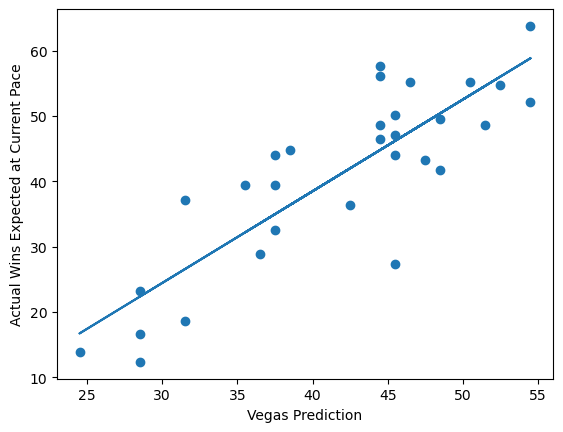

In [415]:
# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel('Vegas Prediction')
plt.ylabel('Actual Wins Expected at Current Pace')

## Question 10:

## Which team has had the best regular season in the last 10 years? In which year? How about worst? In which year? <a class="anchor" id="Question10"></a>

In [592]:
yearly_team_standings_df_ascending = yearly_team_standings_df.sort_values('Win Loss %',ascending=False)
yearly_team_standings_df_ascending.to_excel('yearly_team_standings_df_ascending.xlsx')

PermissionError: [Errno 13] Permission denied: 'yearly_team_standings_df_ascending.xlsx'

In [593]:
yearly_team_standings_df.sort_values('Win Loss %',ascending=True)

,Rk,Team,Overall,Team Wins,Team Losses,Win Loss %,Win Change From Prior Year,Win % Change From Prior Year,Year
119,30,Philadelphia 76ers,10-72,10,72,0.1220,-8.0000,-0.0976,2015
59,30,Milwaukee Bucks,15-67,15,67,0.1829,-23.0000,-0.2805,2013
89,30,Minnesota Timberwolves,16-66,16,66,0.1951,-24.0000,-0.2927,2014
88,29,New York Knicks,17-65,17,65,0.2073,-20.0000,-0.2439,2014
118,29,Los Angeles Lakers,17-65,17,65,0.2073,-4.0000,-0.0488,2015
329,30,Detroit Pistons,17-65,17,65,0.2073,-6.0000,-0.0732,2022
209,30,New York Knicks,17-65,17,65,0.2073,-12.0000,-0.1463,2018
87,28,Philadelphia 76ers,18-64,18,64,0.2195,-1.0000,-0.0122,2014
239,30,Golden State Warriors,15-50,15,50,0.2308,-42.0000,-0.4644,2019
207,28,Cleveland Cavaliers,19-63,19,63,0.2317,-31.0000,-0.3780,2018


## Question 11

## Which team has had the biggest bounce back? In which year? How about falloff? In which year? <a class="anchor" id="Question11"></a>

In [594]:
bounce_back_df = yearly_team_standings_df.sort_values('Win % Change From Prior Year', ascending=False)
bounce_back_df.to_excel('Bounceback_df.xlsx')

PermissionError: [Errno 13] Permission denied: 'Bounceback_df.xlsx'

In [595]:
yearly_team_standings_df.sort_values('Win % Change From Prior Year', ascending=True)

,Rk,Team,Overall,Team Wins,Team Losses,Win Loss %,Win Change From Prior Year,Win % Change From Prior Year,Year
239,30,Golden State Warriors,15-50,15,50,0.2308,-42.0000,-0.4644,2019
207,28,Cleveland Cavaliers,19-63,19,63,0.2317,-31.0000,-0.3780,2018
269,30,Houston Rockets,17-55,17,55,0.2361,-27.0000,-0.3750,2020
263,24,Toronto Raptors,27-45,27,45,0.3750,-26.0000,-0.3611,2020
266,27,Oklahoma City Thunder,22-50,22,50,0.3056,-22.0000,-0.3056,2020
89,30,Minnesota Timberwolves,16-66,16,66,0.1951,-24.0000,-0.2927,2014
59,30,Milwaukee Bucks,15-67,15,67,0.1829,-23.0000,-0.2805,2013
178,29,Memphis Grizzlies,22-60,22,60,0.2683,-21.0000,-0.2561,2017
49,20,Denver Nuggets,36-46,36,46,0.4390,-21.0000,-0.2561,2013
294,25,Portland Trail Blazers,27-55,27,55,0.3293,-15.0000,-0.2541,2021


## Question 12:

## Which team has had the biggest mid-season bounce back? In which year? How about falloff? In which year? <a class="anchor" id="Question12"></a>

In [603]:
all_star_df = yearly_team_standings_full_df[['Team','Overall','Year','Pre All-Star Game Wins','Pre All-Star Game Losses','Pre All-Star Win %','Post All-Star Game Wins','Post All-Star Game Losses','Post All-Star Win %','Difference of Post All-Star Win % and Pre All-Star Win %','Year']]
all_star_df = all_star_df.sort_values('Difference of Post All-Star Win % and Pre All-Star Win %',ascending=False)
all_star_df.to_excel('Allstar.xlsx')

## Question 13: 

## Home-field advantage questions <a class="anchor" id="Question13"></a>

### Teams that performed incredibly worse at home

In [547]:
home_field_df = yearly_team_standings_full_df[['Rk','Team','Overall','Home Game Wins','Home Game Losses','Home Game Win %','Away Game Wins','Away Game Losses','Away Game Win %','Difference of Home Game Win % and Away Game Win %','Year']]

home_field_df.sort_values('Difference of Home Game Win % and Away Game Win %',ascending=True)

,Rk,Team,Overall,Home Game Wins,Home Game Losses,Home Game Win %,Away Game Wins,Away Game Losses,Away Game Win %,Difference of Home Game Win % and Away Game Win %,Year
257,18,Indiana Pacers,34-38,13,23,0.3611,21,15,0.5833,-0.2222,2020
259,20,San Antonio Spurs,33-39,14,22,0.3889,19,17,0.5278,-0.1389,2020
206,27,Chicago Bulls,22-60,9,32,0.2195,13,28,0.3171,-0.0976,2018
283,14,Brooklyn Nets,44-38,20,21,0.4878,24,17,0.5854,-0.0976,2021
221,12,Dallas Mavericks,43-32,20,18,0.5263,23,14,0.6216,-0.0953,2019
238,29,Minnesota Timberwolves,19-45,8,24,0.2500,11,21,0.3438,-0.0938,2019
277,8,Philadelphia 76ers,51-31,24,17,0.5854,27,14,0.6585,-0.0732,2021
288,19,New York Knicks,37-45,17,24,0.4146,20,21,0.4878,-0.0732,2021
226,17,Phoenix Suns,34-39,17,22,0.4359,17,17,0.5000,-0.0641,2019
232,23,Charlotte Hornets,23-42,10,21,0.3226,13,21,0.3824,-0.0598,2019


### Teams that performed incredibly better at home

In [548]:
home_field_df.sort_values('Difference of Home Game Win % and Away Game Win %',ascending=False)

,Rk,Team,Overall,Home Game Wins,Home Game Losses,Home Game Win %,Away Game Wins,Away Game Losses,Away Game Win %,Difference of Home Game Win % and Away Game Win %,Year
222,13,Philadelphia 76ers,43-30,31,4,0.8857,12,26,0.3158,0.5699,2019
310,11,Golden State Warriors,44-38,33,8,0.8049,11,30,0.2683,0.5366,2022
162,13,San Antonio Spurs,47-35,33,8,0.8049,14,27,0.3415,0.4634,2017
305,6,Memphis Grizzlies,51-31,35,6,0.8537,16,25,0.3902,0.4634,2022
218,9,Miami Heat,44-29,29,7,0.8056,15,22,0.4054,0.4002,2019
192,13,San Antonio Spurs,48-34,32,9,0.7805,16,25,0.3902,0.3902,2018
163,14,Denver Nuggets,46-36,31,10,0.7561,15,26,0.3659,0.3902,2017
132,13,Indiana Pacers,42-40,29,12,0.7073,13,28,0.3171,0.3902,2016
201,22,Dallas Mavericks,33-49,24,17,0.5854,9,32,0.2195,0.3659,2018
57,28,Orlando Magic,23-59,19,22,0.4634,4,37,0.0976,0.3659,2013


### Best home team record

In [604]:
home_field_df.sort_values('Home Game Win %',ascending=False)
home_field_df.to_excel('Home Field Yearly.xlsx')

### Which team has the biggest home-field advantage? (average highest difference of Home Game Win% vs. Away?)

In [602]:
# Create dataframe to store info
nba_team_average_homefield_performance_df = pd.DataFrame()
nba_team_average_homefield_performance_df[['Team','Difference of Average Home Game Win % and Away Game Win %','Average Home Game Win %','Average Away Game Win %']] = np.nan


for team in home_field_df['Team'].unique():
    
    home_win_percent = home_field_df.loc[home_field_df['Team']==team]['Home Game Win %'].mean()
    
    away_win_percent = home_field_df.loc[home_field_df['Team']==team]['Away Game Win %'].mean()
    
    difference_value = home_win_percent - away_win_percent
    
    nba_team_average_homefield_performance_df.loc[len(nba_team_average_homefield_performance_df.index)] = team,difference_value,home_win_percent,away_win_percent
    
nba_team_average_homefield_performance_df = nba_team_average_homefield_performance_df.sort_values('Difference of Average Home Game Win % and Away Game Win %',ascending=False)

nba_team_average_homefield_performance_df.to_excel('NBA home field.xlsx')

In [568]:
# Hawks 2023 exploration
home_field_df.loc[home_field_df['Year']==2022].sort_values('Difference of Home Game Win % and Away Game Win %',ascending=False)


,Rk,Team,Overall,Home Game Wins,Home Game Losses,Home Game Win %,Away Game Wins,Away Game Losses,Away Game Win %,Difference of Home Game Win % and Away Game Win %,Year
310,11,Golden State Warriors,44-38,33,8,0.8049,11,30,0.2683,0.5366,2022
305,6,Memphis Grizzlies,51-31,35,6,0.8537,16,25,0.3902,0.4634,2022
303,4,Denver Nuggets,53-29,34,7,0.8293,19,22,0.4634,0.3659,2022
317,18,Toronto Raptors,41-41,27,14,0.6585,14,27,0.3415,0.3171,2022
315,16,New Orleans Pelicans,42-40,27,14,0.6585,15,26,0.3659,0.2927,2022
309,10,Phoenix Suns,45-37,28,13,0.6829,17,24,0.4146,0.2683,2022
304,5,Cleveland Cavaliers,51-31,31,10,0.7561,20,21,0.4878,0.2683,2022
312,13,Miami Heat,44-38,27,14,0.6585,17,24,0.4146,0.2439,2022
321,22,Utah Jazz,37-45,23,18,0.5610,14,27,0.3415,0.2195,2022
320,21,Dallas Mavericks,38-44,23,18,0.5610,15,26,0.3659,0.1951,2022


### How big is the average home-field advantage?

In [569]:
home_field_advantage = home_field_df['Home Game Win %'].mean() - home_field_df['Away Game Win %'].mean()
print(home_field_df['Home Game Win %'].mean())
print(home_field_df['Away Game Win %'].mean())
print(home_field_advantage)

print(home_field_advantage/home_field_df['Away Game Win %'].mean())

0.5714974201399828
0.42763714816305887
0.14386027197692397
0.3364073317645215


# Stage 3 - Export dataframes to Excel <a class="anchor" id="Stage3Step1"></a>

In [ ]:
## Create a copy of Template Sheet and Rename 
wb = load_workbook('NBA Analysis Output.xlsx')

for dataframe_name in list_of_dataframe_names:
    
    ## Assign desired sheet name
    desired_sheet_name = dataframe_name

    ## Create a Copy of Template Sheet
    wb.copy_worksheet(wb['Template Sheet'])

    ## Rename template sheet to desired
    wb['Template Sheet Copy'].title = desired_sheet_name
    

## Save changes to file
wb.save('NBA Analysis Output.xlsx')

In [ ]:
index_count = 0

for dataframe in list_of_dataframes:
    
    print(index_count)
    
    ## DEFINE DESIRED SHEET NAME
    desired_sheet_name = list_of_dataframe_names[index_count]

    ## Write to newly created sheet 
    with pd.ExcelWriter('NBA Analysis Output.xlsx', engine='openpyxl', mode='a',if_sheet_exists='overlay') as writer:

        ## Write the new DataFrame to a new sheet
        dataframe.to_excel(writer, sheet_name=desired_sheet_name, index=False)
        
    ## Change index counter
    index_count = index_count + 1
    
## Save changes to file
writer.close# Stage 3 - Export dataframes to Excel <a class="anchor" id="Stage3Step1"></a>

# Stage 4 - Regression analysis to try to predict rookie success using combine stats <a class="anchor" id="Stage4Step1"></a>

## Which combine stats most explain rookie success? How does it vary by position?

### Determine which players we have combine information for 

In [76]:
# Get list of player names that we have draft combine stats of 
combine_players = combine_stats_df['player_name']

# Check for duplicate player names
print(len(combine_players))
print(len(set(combine_players)))

# Identify duplicate player names
temp_list = []
duplicate_list = []

for player in combine_players:
    
    # If name already in list because of duplicate, print name
    if player in temp_list:
        duplicate_list.append(player)
    
    # If not, append to list because it's the first occurence
    temp_list.append(player)

# Get list of all player names
combine_player_names = list(combine_stats_df['player_name'].unique())

# Remove duplicate names just to clean things up and avoid situations where players get measured in two different drafts
# or where two players share the same name
for player in duplicate_list:
    
    while player in combine_player_names:
        
        # Remove player name values from list
        combine_player_names.remove(player)
        print(f'{player} was removed')
    

# Check for duplicates again to make sure we addressed
print(len(combine_player_names))
print(len(set(combine_player_names)))

838
832
Drago Pasalic was removed
Tony Mitchell was removed
Marcus Thornton was removed
Rawle Alkins was removed
Hamidou Diallo was removed
Moritz Wagner was removed
826
826


### For player we have draft combine stats for, populate a new dataframe with their name and total win shares their first four years

In [77]:
# Create a list of players that we have both draft combine stats and yearly player stats for 
list_of_combine_players_in_yearly_stats_df = []

for player in combine_player_names:
    
    if player in yearly_player_stats_df['Player'].unique():
        
        list_of_combine_players_in_yearly_stats_df.append(player)
        
print(f'{len(list_of_combine_players_in_yearly_stats_df)} out of {len(combine_player_names)} were found to have yearly player stats available')   

# Create a blank dataframe to populate
combine_players_combined_rookie_performance_df = pd.DataFrame()
combine_players_combined_rookie_performance_df[['Player','Year Drafted','Total Rookie Win Shares']] = np.nan

# Iterate through yearly stats df to populate newly created dataframe
for player in list_of_combine_players_in_yearly_stats_df: 
    
    # Define their first year playing in the league
    first_year = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player]['Year'].min()
    
    # Filter on their first four years
    last_rookie_year = first_year + 3
    temporary_player_df = yearly_player_stats_df.loc[(yearly_player_stats_df['Player']==player)&(yearly_player_stats_df['Year']>=first_year)&(yearly_player_stats_df['Year']<=last_rookie_year)]
    
    # Determine cumulative win shares their first four years
    total_rookie_win_shares = temporary_player_df['WS'].sum()
                                                    
    # Finally, populate dataframe
    combine_players_combined_rookie_performance_df.loc[len(combine_players_combined_rookie_performance_df.index)] = player,first_year,total_rookie_win_shares
                                                     
combine_players_combined_rookie_performance_df.head(5)


579 out of 826 were found to have yearly player stats available


,Player,Year Drafted,Total Rookie Win Shares
0,Tony Allen,2004,9.0000
1,Trevor Ariza,2004,8.2000
2,Andre Barrett,2004,0.3000
3,Brandon Bass,2005,8.5000
4,Andris Biedriņš,2004,18.8000


### Merge newly created dataframe with the combine stats dataframe so we can get combine info + win share info in one table

In [94]:
# Merge combine dataframe with newly created dataframe
combine_merged_df = combine_players_combined_rookie_performance_df.merge(combine_stats_df,how='left',left_on='Player',right_on='player_name')

# Rename Columns for Legibility
col_rename_dict = {'height_wo_shoes':'Height Without Shoes (in.)',
                   'weight':'Weight (lbs)',
                   'wingspan':'Wingspan (in.)',
                   'standing_reach':'Standing Reach (in.)',
                   'body_fat_pct':'Body Fat Percentage',
                   'standing_vertical_leap':'Standing Vertical Leap (in.)',
                   'max_vertical_leap':'Max Vertical Leap (in.)',
                   'hand_length':'Hand Length (in.)',
                   'hand_width':'Hand Width (in.)',
                   'lane_agility_time':'Lane Agility Time (sec.)',
                   'modified_lane_agility_time':'Modified Lane Agility Time (sec.)',
                   'three_quarter_sprint':'3/4 Court Sprint Time (sec.)',
                   'bench_press':'Bench Press (reps)'}

# Rename columns
combine_merged_df.rename(col_rename_dict,axis='columns',inplace=True)

# Create new column
combine_merged_df['Ape Index'] = combine_merged_df['Wingspan (in.)'] - combine_merged_df['Height Without Shoes (in.)']

combine_merged_df

,Player,Year Drafted,Total Rookie Win Shares,season,player_id,first_name,last_name,player_name,position,Height Without Shoes (in.),...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
0,Tony Allen,2004,9.0000,2004,2754,Tony,Allen,Tony Allen,SG,75.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Trevor Ariza,2004,8.2000,2004,2772,Trevor,Ariza,Trevor Ariza,SG-SF,79.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Andre Barrett,2004,0.3000,2004,2857,Andre,Barrett,Andre Barrett,PG,68.7500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Brandon Bass,2005,8.5000,2004,101138,Brandon,Bass,Brandon Bass,PF,78.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andris Biedriņš,2004,18.8000,2004,2740,Andris,Biedrins,Andris Biedriņš,C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,Khyri Thomas,2018,0.5000,2018,1629017,Khyri,Thomas,Khyri Thomas,SG,74.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575,Gary Trent,2003,2.3000,2018,1629018,Gary,Trent,Gary Trent,SG,76.2500,...,3-5,2-5,4-4,3-4,4-4,NaN,NaN,NaN,18-25,NaN
576,Allonzo Trier,2018,1.4000,2018,1629019,Allonzo,Trier,Allonzo Trier,SG,75.7500,...,4-5,3-5,4-4,1-4,1-4,2-4,4-4,4-4,20-28,NaN
577,Kenrich Williams,2018,6.7000,2018,1629026,Kenrich,Williams,Kenrich Williams,SF,78.0000,...,4-5,1-5,3-8,2-8,2-8,NaN,NaN,NaN,19-29,NaN


### Look at predicting success by position: Center

In [611]:
# Create dataframe
r_squared_df = pd.DataFrame(columns=['Variable','R-squared Value','Sample Size','Max Value','Min Value','Mean Value','Median Value'])

# Define variables
list_of_variables = ['Height Without Shoes (in.)',
                     'Weight (lbs)',
                     'Wingspan (in.)',
                     'Standing Reach (in.)',
                     'Body Fat Percentage',
                     'Standing Vertical Leap (in.)',
                     'Max Vertical Leap (in.)',
                     'Hand Length (in.)',
                     'Hand Width (in.)',
                     'Lane Agility Time (sec.)',
                     'Modified Lane Agility Time (sec.)',
                     '3/4 Court Sprint Time (sec.)',
                     'Bench Press (reps)',
                     'Ape Index']

# Define position of interest
position = 'C'

for variable in list_of_variables:
    
    # Drop all players without stat recorded
    temporary_df = combine_merged_df
    temporary_df = temporary_df.loc[(temporary_df[variable].notnull())&(temporary_df['position']==position)]
    
    # Check to see if we have a sample size of at least 100 players with the stat recorded
    sample_size = len(temporary_df)
    
    # Define median
    average_value = temporary_df[variable].mean()
    median_value = temporary_df[variable].median()
    max_value = temporary_df[variable].max()
    min_value = temporary_df[variable].min()

    # Initiate linear regression model
    model = LinearRegression()

    # Define predictor and response variables
    X = temporary_df[variable]
    Y = temporary_df['Total Rookie Win Shares']

    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)

    # Fit regression model
    model.fit(X, Y)

    # Calculate R-squared of regression model
    r_squared = model.score(X, Y)

    # Write results to dataframe created above
    r_squared_df.loc[len(r_squared_df.index)]=variable,r_squared,sample_size,max_value,min_value,average_value,median_value

# Sort, reset index, and display output
r_squared_df.sort_values('R-squared Value',ascending=False,inplace=True)
r_squared_df.reset_index(inplace=True,drop=True)
r_squared_df

,Variable,R-squared Value,Sample Size,Max Value,Min Value,Mean Value,Median Value
0,Hand Length (in.),0.26,24,9.75,8.50,9.23,9.25
1,Wingspan (in.),0.19,34,92.50,85.00,88.24,88.25
2,Modified Lane Agility Time (sec.),0.13,12,3.65,2.94,3.20,3.22
3,Ape Index,0.11,33,9.75,1.75,5.86,5.75
4,Standing Vertical Leap (in.),0.08,27,32.00,22.50,26.89,26.50
5,Max Vertical Leap (in.),0.07,27,35.50,25.00,30.52,31.00
6,Body Fat Percentage,0.07,34,16.40,4.15,8.40,7.55
7,Lane Agility Time (sec.),0.03,27,13.32,10.83,12.13,12.14
8,Bench Press (reps),0.03,25,19.00,1.00,10.00,10.00
9,Standing Reach (in.),0.01,33,115.00,108.00,111.08,111.00


Text(0, 0.5, 'Total Rookie Win Shares')

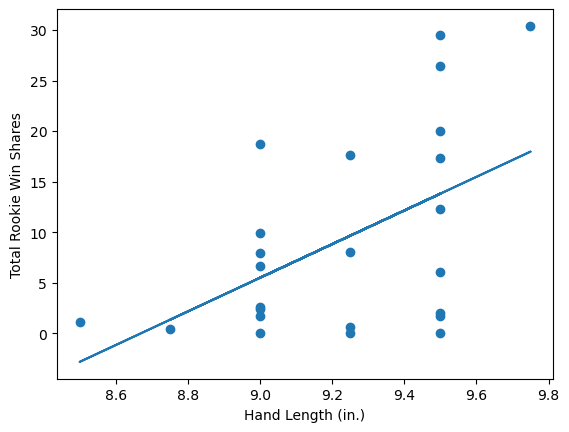

In [218]:
index_of_interest = 0

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

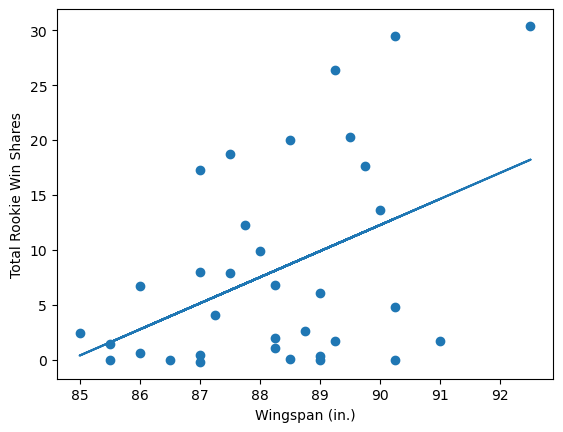

In [219]:
index_of_interest = 1

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

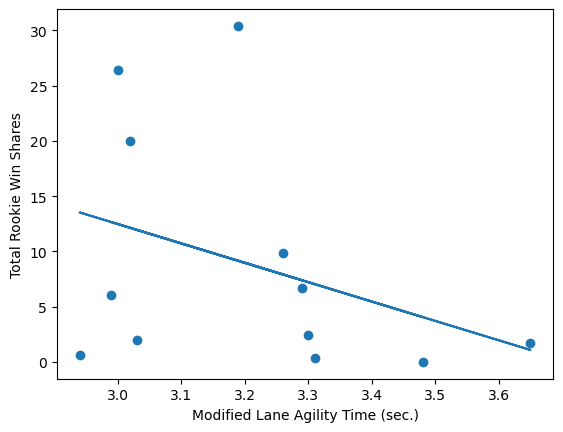

In [220]:
index_of_interest = 2

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

### Look at predicting success by position: Power Forward

In [221]:
# Create dataframe
r_squared_df = pd.DataFrame(columns=['Variable','R-squared Value','Sample Size','Max Value','Min Value','Mean Value','Median Value'])

# Define variables
list_of_variables = ['Height Without Shoes (in.)',
                     'Weight (lbs)',
                     'Wingspan (in.)',
                     'Standing Reach (in.)',
                     'Body Fat Percentage',
                     'Standing Vertical Leap (in.)',
                     'Max Vertical Leap (in.)',
                     'Hand Length (in.)',
                     'Hand Width (in.)',
                     'Lane Agility Time (sec.)',
                     'Modified Lane Agility Time (sec.)',
                     '3/4 Court Sprint Time (sec.)',
                     'Bench Press (reps)',
                     'Ape Index']

# Define position of interest
position = 'PF'

for variable in list_of_variables:
    
    # Drop all players without stat recorded
    temporary_df = combine_merged_df
    temporary_df = temporary_df.loc[(temporary_df[variable].notnull())&(temporary_df['position']==position)]
    
    # Check to see if we have a sample size of at least 100 players with the stat recorded
    sample_size = len(temporary_df)
    
    # Define median
    average_value = temporary_df[variable].mean()
    median_value = temporary_df[variable].median()
    max_value = temporary_df[variable].max()
    min_value = temporary_df[variable].min()

    # Initiate linear regression model
    model = LinearRegression()

    # Define predictor and response variables
    X = temporary_df[variable]
    Y = temporary_df['Total Rookie Win Shares']

    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)

    # Fit regression model
    model.fit(X, Y)

    # Calculate R-squared of regression model
    r_squared = model.score(X, Y)

    # Write results to dataframe created above
    r_squared_df.loc[len(r_squared_df.index)]=variable,r_squared,sample_size,max_value,min_value,average_value,median_value

# Sort, reset index, and display output
r_squared_df.sort_values('R-squared Value',ascending=False,inplace=True)
r_squared_df.reset_index(inplace=True,drop=True)
r_squared_df

,Variable,R-squared Value,Sample Size,Max Value,Min Value,Mean Value,Median Value
0,Bench Press (reps),0.1220,80,23.0000,0.0000,12.7875,13.0000
1,Standing Vertical Leap (in.),0.0660,91,33.5000,24.0000,29.0879,29.0000
2,Lane Agility Time (sec.),0.0573,89,12.7800,10.4800,11.5893,11.5900
3,Max Vertical Leap (in.),0.0351,91,39.5000,27.5000,33.6923,33.5000
4,Modified Lane Agility Time (sec.),0.0163,31,3.5400,2.7600,3.1658,3.2000
5,Ape Index,0.0136,106,10.2500,0.0000,5.4788,5.2500
6,Wingspan (in.),0.0122,106,89.0000,80.7500,85.2972,85.2500
7,3/4 Court Sprint Time (sec.),0.0115,90,3.8100,3.1000,3.3348,3.2900
8,Hand Width (in.),0.0099,73,11.7500,7.7500,9.7226,9.7500
9,Weight (lbs),0.0071,106,280.0000,182.2000,235.1000,236.8000


Text(0, 0.5, 'Total Rookie Win Shares')

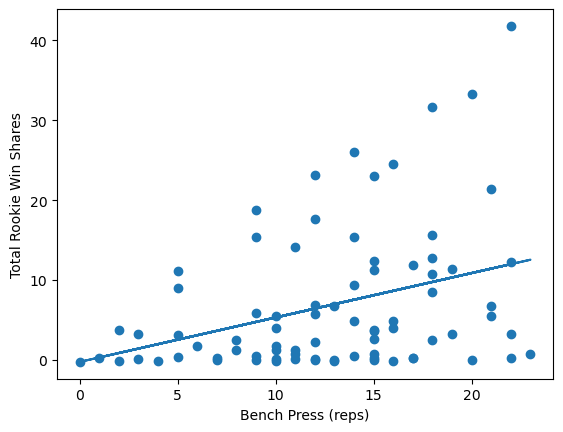

In [222]:
index_of_interest = 0

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

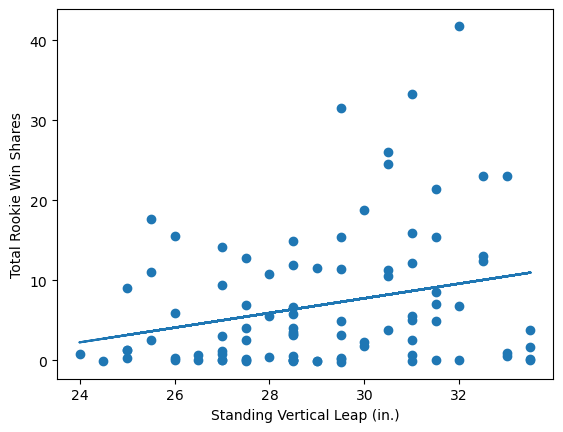

In [223]:
index_of_interest = 1

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

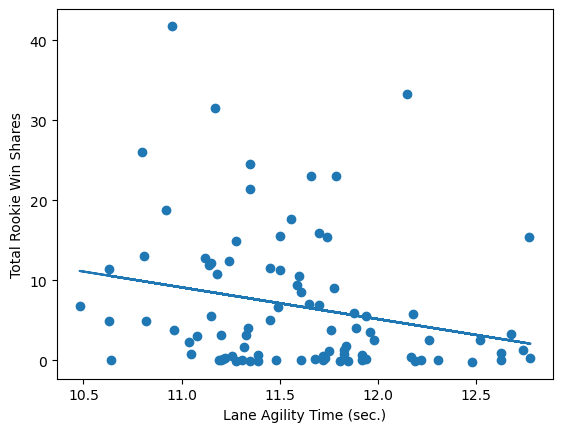

In [224]:
index_of_interest = 2

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

### Look at predicting success by position: Small Forward

In [234]:
# Create dataframe
r_squared_df = pd.DataFrame(columns=['Variable','R-squared Value','Sample Size','Max Value','Min Value','Mean Value','Median Value'])

# Define variables
list_of_variables = ['Height Without Shoes (in.)',
                     'Weight (lbs)',
                     'Wingspan (in.)',
                     'Standing Reach (in.)',
                     'Body Fat Percentage',
                     'Standing Vertical Leap (in.)',
                     'Max Vertical Leap (in.)',
                     'Hand Length (in.)',
                     'Hand Width (in.)',
                     'Lane Agility Time (sec.)',
                     'Modified Lane Agility Time (sec.)',
                     '3/4 Court Sprint Time (sec.)',
                     'Bench Press (reps)',
                     'Ape Index']

# Define position of interest
position = 'SF'

for variable in list_of_variables:
    
    # Drop all players without stat recorded
    temporary_df = combine_merged_df
    temporary_df = temporary_df.loc[(temporary_df[variable].notnull())&(temporary_df['position']==position)]
    
    # Check to see if we have a sample size of at least 100 players with the stat recorded
    sample_size = len(temporary_df)
    
    # Define median
    average_value = temporary_df[variable].mean()
    median_value = temporary_df[variable].median()
    max_value = temporary_df[variable].max()
    min_value = temporary_df[variable].min()

    # Initiate linear regression model
    model = LinearRegression()

    # Define predictor and response variables
    X = temporary_df[variable]
    Y = temporary_df['Total Rookie Win Shares']

    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)

    # Fit regression model
    model.fit(X, Y)

    # Calculate R-squared of regression model
    r_squared = model.score(X, Y)

    # Write results to dataframe created above
    r_squared_df.loc[len(r_squared_df.index)]=variable,r_squared,sample_size,max_value,min_value,average_value,median_value

# Sort, reset index, and display output
r_squared_df.sort_values('R-squared Value',ascending=False,inplace=True)
r_squared_df.reset_index(inplace=True,drop=True)
r_squared_df

,Variable,R-squared Value,Sample Size,Max Value,Min Value,Mean Value,Median Value
0,Bench Press (reps),0.0760,45,26.0000,2.0000,10.4889,11.0000
1,Modified Lane Agility Time (sec.),0.0589,15,3.6100,2.9100,3.1427,3.1400
2,Weight (lbs),0.0401,61,243.0000,186.8000,217.1279,218.0000
3,Max Vertical Leap (in.),0.0344,52,41.5000,29.5000,35.0962,35.5000
4,Height Without Shoes (in.),0.0240,61,80.7500,76.0000,78.3320,78.2500
5,Standing Vertical Leap (in.),0.0198,52,36.5000,22.0000,29.4712,29.2500
6,Hand Width (in.),0.0169,43,11.2500,7.2500,9.4593,9.5000
7,Ape Index,0.0160,61,9.0000,0.7500,4.8131,4.7500
8,Lane Agility Time (sec.),0.0118,52,12.8500,10.3900,11.3487,11.3600
9,Hand Length (in.),0.0041,43,9.7500,8.2500,8.8372,8.7500


Text(0, 0.5, 'Total Rookie Win Shares')

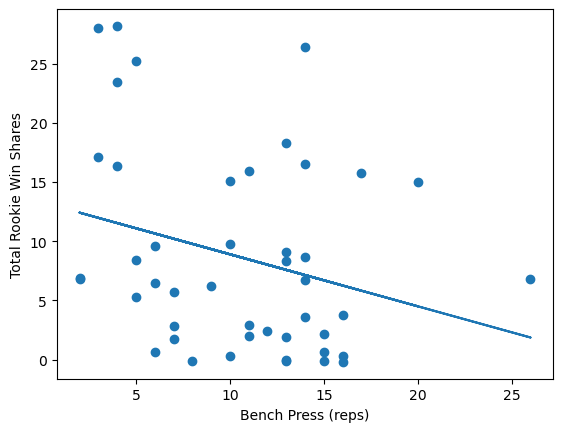

In [235]:
index_of_interest = 0

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

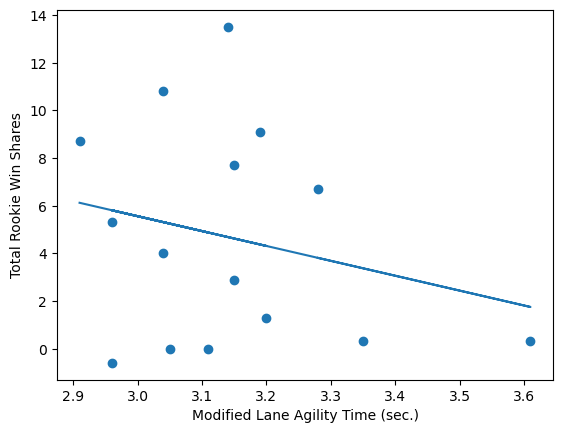

In [236]:
index_of_interest = 1

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

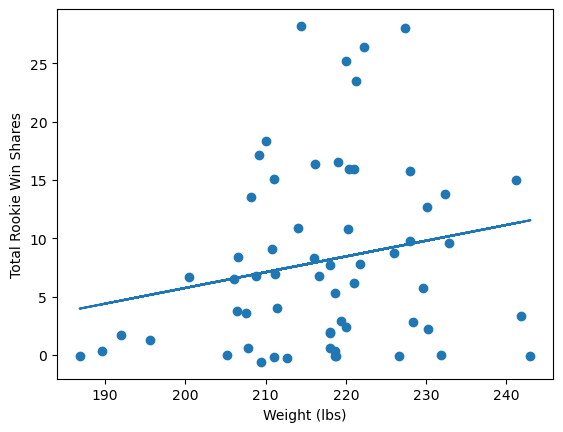

In [237]:
index_of_interest = 2

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

### Look at predicting success by position: Shooting Guard

In [226]:
# Create dataframe
r_squared_df = pd.DataFrame(columns=['Variable','R-squared Value','Sample Size','Max Value','Min Value','Mean Value','Median Value'])

# Define variables
list_of_variables = ['Height Without Shoes (in.)',
                     'Weight (lbs)',
                     'Wingspan (in.)',
                     'Standing Reach (in.)',
                     'Body Fat Percentage',
                     'Standing Vertical Leap (in.)',
                     'Max Vertical Leap (in.)',
                     'Hand Length (in.)',
                     'Hand Width (in.)',
                     'Lane Agility Time (sec.)',
                     'Modified Lane Agility Time (sec.)',
                     '3/4 Court Sprint Time (sec.)',
                     'Bench Press (reps)',
                     'Ape Index']

# Define position of interest
position = 'SG'

for variable in list_of_variables:
    
    # Drop all players without stat recorded
    temporary_df = combine_merged_df
    temporary_df = temporary_df.loc[(temporary_df[variable].notnull())&(temporary_df['position']==position)]
    
    # Check to see if we have a sample size of at least 100 players with the stat recorded
    sample_size = len(temporary_df)
    
    # Define median
    average_value = temporary_df[variable].mean()
    median_value = temporary_df[variable].median()
    max_value = temporary_df[variable].max()
    min_value = temporary_df[variable].min()

    # Initiate linear regression model
    model = LinearRegression()

    # Define predictor and response variables
    X = temporary_df[variable]
    Y = temporary_df['Total Rookie Win Shares']

    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)

    # Fit regression model
    model.fit(X, Y)

    # Calculate R-squared of regression model
    r_squared = model.score(X, Y)

    # Write results to dataframe created above
    r_squared_df.loc[len(r_squared_df.index)]=variable,r_squared,sample_size,max_value,min_value,average_value,median_value

# Sort, reset index, and display output
r_squared_df.sort_values('R-squared Value',ascending=False,inplace=True)
r_squared_df.reset_index(inplace=True,drop=True)
r_squared_df

,Variable,R-squared Value,Sample Size,Max Value,Min Value,Mean Value,Median Value
0,3/4 Court Sprint Time (sec.),0.0873,78,3.5000,3.0100,3.2377,3.2450
1,Body Fat Percentage,0.0389,84,12.0500,3.8000,6.5958,6.2000
2,Max Vertical Leap (in.),0.0365,79,44.0000,29.5000,36.3797,36.0000
3,Weight (lbs),0.0359,87,228.8000,172.0000,202.7874,202.4000
4,Standing Vertical Leap (in.),0.0356,79,37.5000,23.5000,30.1646,30.5000
5,Lane Agility Time (sec.),0.0289,76,12.6200,10.2700,11.0320,10.9750
6,Bench Press (reps),0.0042,65,21.0000,0.0000,10.0615,10.0000
7,Hand Length (in.),0.0041,66,9.2500,8.0000,8.6023,8.5000
8,Modified Lane Agility Time (sec.),0.0025,37,3.4100,2.7000,3.0411,3.0500
9,Hand Width (in.),0.0014,66,10.5000,7.5000,9.2652,9.2500


Text(0, 0.5, 'Total Rookie Win Shares')

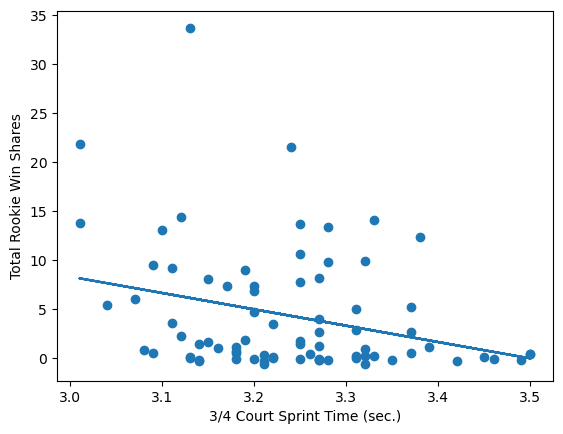

In [227]:
index_of_interest = 0

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

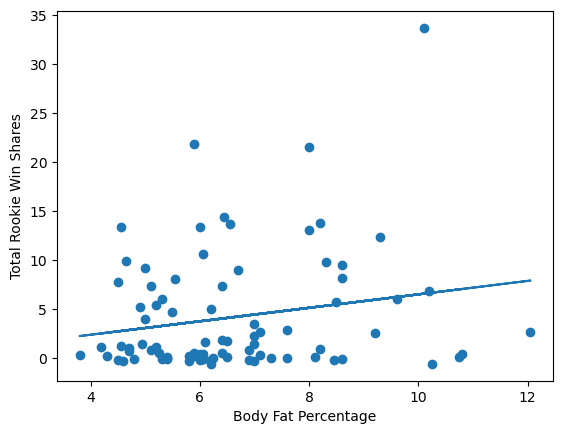

In [228]:
index_of_interest = 1

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

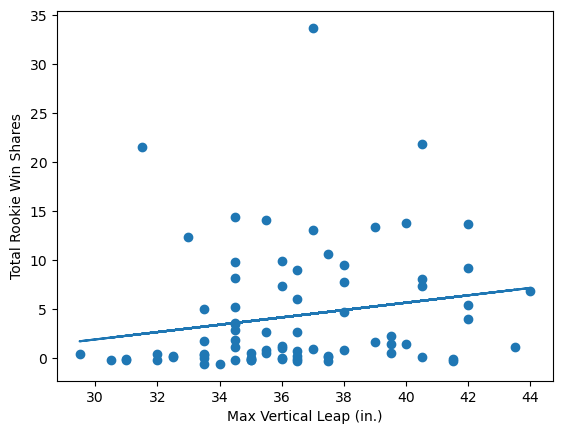

In [229]:
index_of_interest = 2

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

### Look at predicting success by position: Point Guard

In [230]:
# Create dataframe
r_squared_df = pd.DataFrame(columns=['Variable','R-squared Value','Sample Size','Max Value','Min Value','Mean Value','Median Value'])

# Define variables
list_of_variables = ['Height Without Shoes (in.)',
                     'Weight (lbs)',
                     'Wingspan (in.)',
                     'Standing Reach (in.)',
                     'Body Fat Percentage',
                     'Standing Vertical Leap (in.)',
                     'Max Vertical Leap (in.)',
                     'Hand Length (in.)',
                     'Hand Width (in.)',
                     'Lane Agility Time (sec.)',
                     'Modified Lane Agility Time (sec.)',
                     '3/4 Court Sprint Time (sec.)',
                     'Bench Press (reps)',
                     'Ape Index']

# Define position of interest
position = 'PG'

for variable in list_of_variables:
    
    # Drop all players without stat recorded
    temporary_df = combine_merged_df
    temporary_df = temporary_df.loc[(temporary_df[variable].notnull())&(temporary_df['position']==position)]
    
    # Check to see if we have a sample size of at least 100 players with the stat recorded
    sample_size = len(temporary_df)
    
    # Define median
    average_value = temporary_df[variable].mean()
    median_value = temporary_df[variable].median()
    max_value = temporary_df[variable].max()
    min_value = temporary_df[variable].min()

    # Initiate linear regression model
    model = LinearRegression()

    # Define predictor and response variables
    X = temporary_df[variable]
    Y = temporary_df['Total Rookie Win Shares']

    X = np.array(X).reshape(-1,1)
    Y = np.array(Y).reshape(-1,1)

    # Fit regression model
    model.fit(X, Y)

    # Calculate R-squared of regression model
    r_squared = model.score(X, Y)

    # Write results to dataframe created above
    r_squared_df.loc[len(r_squared_df.index)]=variable,r_squared,sample_size,max_value,min_value,average_value,median_value

# Sort, reset index, and display output
r_squared_df.sort_values('R-squared Value',ascending=False,inplace=True)
r_squared_df.reset_index(inplace=True,drop=True)
r_squared_df

,Variable,R-squared Value,Sample Size,Max Value,Min Value,Mean Value,Median Value
0,3/4 Court Sprint Time (sec.),0.0532,95,3.4000,2.9600,3.1949,3.1900
1,Hand Width (in.),0.0367,67,10.5000,7.7500,9.0075,9.0000
2,Bench Press (reps),0.0257,87,18.0000,0.0000,8.7126,8.0000
3,Standing Vertical Leap (in.),0.0219,96,35.5000,24.5000,30.4193,30.5000
4,Hand Length (in.),0.0035,67,9.2500,7.5000,8.3209,8.2500
5,Modified Lane Agility Time (sec.),0.0032,39,3.7000,2.7000,3.0597,3.0300
6,Ape Index,0.0030,109,9.0000,0.2500,4.5780,4.5000
7,Wingspan (in.),0.0029,109,83.5000,70.0000,77.4450,77.5000
8,Max Vertical Leap (in.),0.0021,95,44.0000,28.5000,36.6000,36.5000
9,Body Fat Percentage,0.0003,100,12.4000,2.7000,6.0210,5.6750


Text(0, 0.5, 'Total Rookie Win Shares')

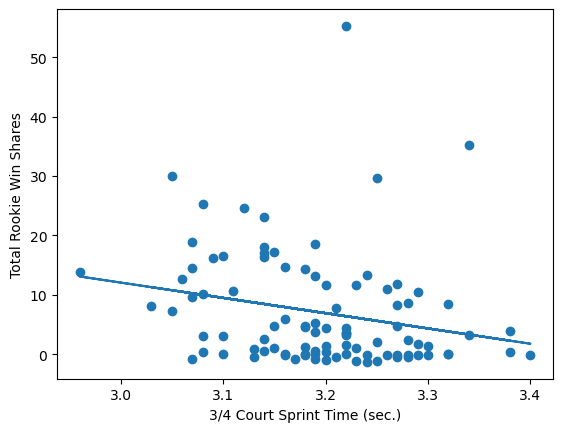

In [231]:
index_of_interest = 0

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

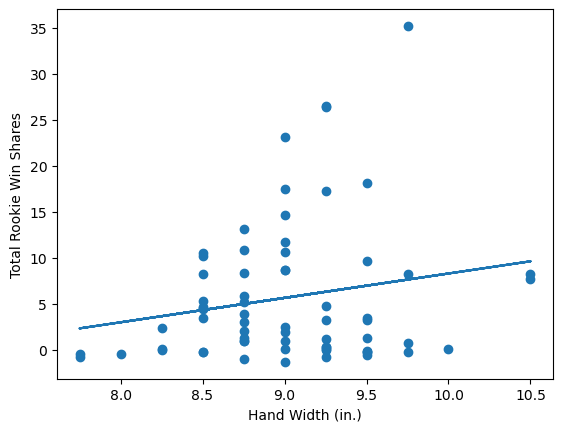

In [232]:
index_of_interest = 1

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

Text(0, 0.5, 'Total Rookie Win Shares')

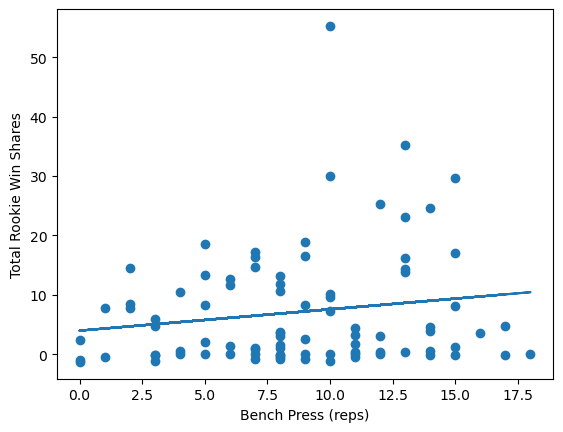

In [233]:
index_of_interest = 2

# Define variable using index above and 
variable = r_squared_df['Variable'][index_of_interest]
temporary_df = combine_merged_df.loc[(combine_merged_df[variable].notnull())&(combine_merged_df['position']==position)]

# Define X and Y variables
x = temporary_df[variable]
y = temporary_df['Total Rookie Win Shares']

# Create scatterplot
plt.scatter(x,y)

# Determine a and b to help plot line of best fit
a, b = np.polyfit(x, y, 1)

# Plot line of best fit against scatterplot points
plt.plot(x, a*x+b)  

# Define labels
plt.xlabel(variable)
plt.ylabel('Total Rookie Win Shares')

# Stage 5: How much does age impact expected total win shares? Are older players actually playing better than they did in the past? <a class="anchor" id="Stage5"></a>

In [346]:
## Question 3: How much does age impact expected total win shares? How has Lebron's last few years compared to the average for his ages? 

# Create 4 year subsets/eras
era_subset_1 = [2003,2004,2005,2006,2007]
era_subset_2 = [2008,2009,2010,2011,2012]
era_subset_3 = [2013,2014,2015,2016,2017]
era_subset_4 = [2018,2019,2020,2021,2022]

list_of_eras = [era_subset_1,
                era_subset_2,
                era_subset_3,
                era_subset_4]

# Create 2 age brackets to represent older athletes
age_bracket_1 = [19,20,21]
age_bracket_2 = [22,23,24]
age_bracket_3 = [25,26,27]
age_bracket_4 = [28,29,30]
age_bracket_5 = [31,32,33]
age_bracket_6 = [34,35,36]
age_bracket_7 = [35,36,37]
age_bracket_8 = [38,39,40]

list_of_age_brackets = [age_bracket_1,
                        age_bracket_2,
                        age_bracket_3,
                        age_bracket_4,
                        age_bracket_5,
                        age_bracket_6,
                        age_bracket_7,
                        age_bracket_8]

# Create a dataframe to store average win shares vs. average age bracket info for different eras
age_performance_in_different_eras_df = pd.DataFrame()
age_performance_in_different_eras_df[['Era','Age Bracket','Mean Win Share of Players','Median Win Share of Players','Max Win Shares','Min Win Shares','90% Win Share Quartile']] = np.nan

# For eras, iterate through and populate how the different age_subsets performed using win shares
for era in list_of_eras:
    
    # Define era_df
    era_df = yearly_player_stats_df.loc[yearly_player_stats_df['Year'].isin(era)]
    
    for age_bracket in list_of_age_brackets:
        
        # Determine value of median win share
        median_ws_value = era_df.loc[era_df['Age'].isin(age_bracket)]['WS'].median()
        
        # Determine mean value of win share
        mean_ws_value = era_df.loc[era_df['Age'].isin(age_bracket)]['WS'].mean()
        
        # Determine max value of win share
        max_ws_value = era_df.loc[era_df['Age'].isin(age_bracket)]['WS'].max()
        
        # Determine 95% quartile
        value_90_quartile = np.percentile(era_df.loc[era_df['Age'].isin(age_bracket)]['WS'],90)
        
        # Determine min value of win share
        min_ws_value = era_df.loc[era_df['Age'].isin(age_bracket)]['WS'].min()
        
        # Populate dataframe
        age_performance_in_different_eras_df.loc[len(age_performance_in_different_eras_df.index)]=str(era),str(age_bracket),mean_ws_value,median_ws_value,max_ws_value,min_ws_value,value_90_quartile

age_performance_in_different_eras_df.sort_values('Age Bracket')

,Era,Age Bracket,Mean Win Share of Players,Median Win Share of Players,Max Win Shares,Min Win Shares,90% Win Share Quartile
0,"[2003, 2004, 2005, 2006, 2007]","[19, 20, 21]",2.1190,1.1000,16.3000,-0.5000,5.7400
24,"[2018, 2019, 2020, 2021, 2022]","[19, 20, 21]",1.3087,0.6000,8.8000,-1.9000,3.7600
8,"[2008, 2009, 2010, 2011, 2012]","[19, 20, 21]",2.1979,1.6000,16.1000,-1.3000,5.4000
16,"[2013, 2014, 2015, 2016, 2017]","[19, 20, 21]",1.6470,0.8000,14.0000,-2.1000,4.2000
1,"[2003, 2004, 2005, 2006, 2007]","[22, 23, 24]",2.3365,1.2000,17.8000,-1.5000,6.8000
25,"[2018, 2019, 2020, 2021, 2022]","[22, 23, 24]",1.7790,0.9000,14.4000,-0.9000,5.0300
17,"[2013, 2014, 2015, 2016, 2017]","[22, 23, 24]",2.0790,1.1000,14.3000,-0.9000,5.9000
9,"[2008, 2009, 2010, 2011, 2012]","[22, 23, 24]",2.4221,1.5000,20.3000,-1.5000,6.2000
2,"[2003, 2004, 2005, 2006, 2007]","[25, 26, 27]",3.3483,2.5000,18.3000,-0.8000,8.1400
18,"[2013, 2014, 2015, 2016, 2017]","[25, 26, 27]",3.0511,2.3000,19.2000,-0.8000,7.2400


### Plotting Max Win Shares for different age brackets across different eras

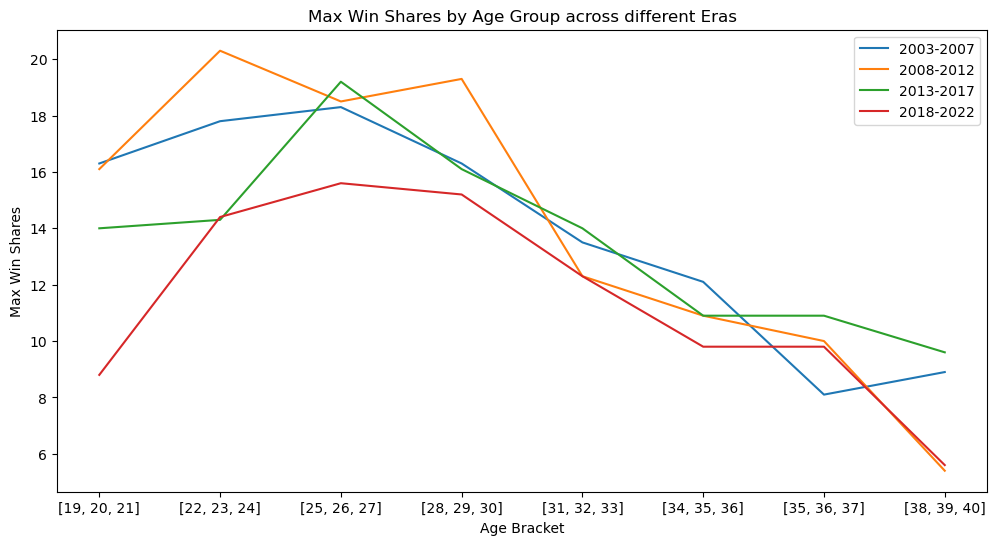

In [347]:
# Define column of interest for y-axis
column_of_interest = 'Max Win Shares'

plt.figure(figsize=(12,6))

# Plot Era 1
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2003, 2004, 2005, 2006, 2007]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2003-2007")

# Plot 2
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2008, 2009, 2010, 2011, 2012]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2008-2012")

# Plot 3
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2013, 2014, 2015, 2016, 2017]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2013-2017")

# Plot Era 4
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2018, 2019, 2020, 2021, 2022]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2018-2022")

# Display
plt.xlabel("Age Bracket")
plt.ylabel(column_of_interest)
plt.title(f'{column_of_interest} by Age Group across different Eras')

plt.legend() 
plt.show()

### Plotting 95% Win Share Quartile Value for different age brackets across different eras

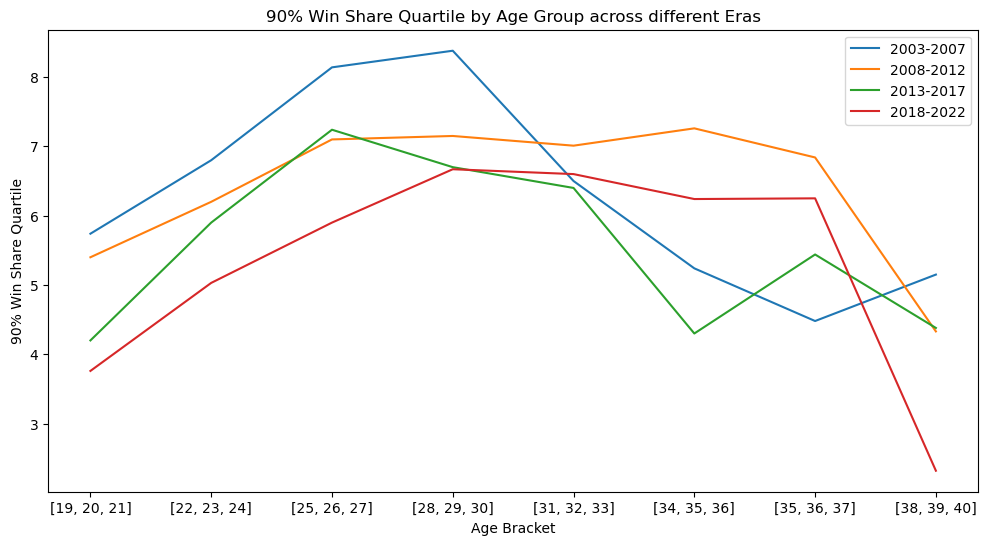

In [348]:
# Define column of interest for y-axis
column_of_interest = '90% Win Share Quartile'

plt.figure(figsize=(12,6))

# Plot Era 1
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2003, 2004, 2005, 2006, 2007]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2003-2007")

# Plot 2
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2008, 2009, 2010, 2011, 2012]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2008-2012")

# Plot 3
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2013, 2014, 2015, 2016, 2017]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2013-2017")

# Plot Era 4
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2018, 2019, 2020, 2021, 2022]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2018-2022")

# Display
plt.xlabel("Age Bracket")
plt.ylabel(column_of_interest)
plt.title(f'{column_of_interest} by Age Group across different Eras')

plt.legend() 
plt.show()

### Plotting Mean Win Shares for different age brackets across different eras

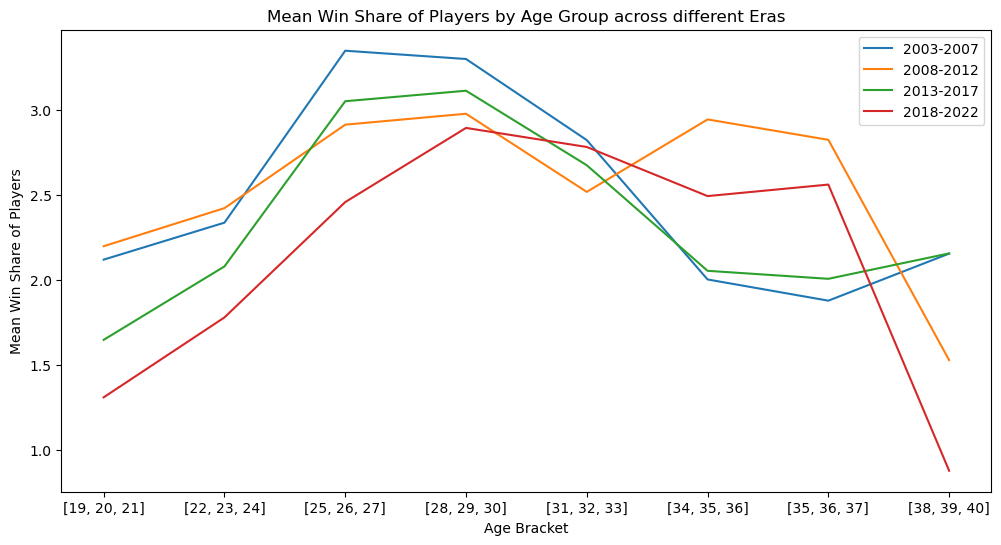

In [349]:
# Define column of interest for y-axis
column_of_interest = 'Mean Win Share of Players'

plt.figure(figsize=(12,6))

# Plot Era 1
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2003, 2004, 2005, 2006, 2007]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2003-2007")

# Plot 2
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2008, 2009, 2010, 2011, 2012]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2008-2012")

# Plot 3
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2013, 2014, 2015, 2016, 2017]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2013-2017")

# Plot Era 4
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2018, 2019, 2020, 2021, 2022]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2018-2022")

# Display
plt.xlabel("Age Bracket")
plt.ylabel(column_of_interest)
plt.title(f'{column_of_interest} by Age Group across different Eras')

plt.legend() 
plt.show()

### Plotting Median Win Shares for different age brackets across different eras

In [350]:
yearly_player_stats_df.loc[yearly_player_stats_df['Player']=='LeBron James']

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player-additional,Year
202,203,LeBron James,SG,19,CLE,79,3122,18.3000,0.4880,0.1450,...,2.6000,5.1000,0.0780,NaN,2.3000,-0.6000,1.7000,2.9000,jamesle01,2003
656,215,LeBron James,SF,20,CLE,80,3388,25.7000,0.5540,0.1830,...,4.6000,14.3000,0.2030,NaN,7.0000,1.7000,8.6000,9.1000,jamesle01,2004
1112,207,LeBron James,SF,21,CLE,79,3361,28.1000,0.5680,0.2080,...,4.3000,16.3000,0.2320,NaN,7.5000,1.6000,9.1000,9.4000,jamesle01,2005
1570,207,LeBron James,SF,22,CLE,78,3190,24.5000,0.5520,0.1910,...,5.7000,13.7000,0.2060,NaN,5.9000,2.2000,8.1000,8.1000,jamesle01,2006
2032,211,LeBron James,SF,23,CLE,75,3027,29.1000,0.5680,0.2190,...,4.6000,15.2000,0.2420,NaN,8.2000,2.6000,10.9000,9.8000,jamesle01,2007
2479,208,LeBron James,SF,24,CLE,81,3054,31.7000,0.5910,0.2380,...,6.5000,20.3000,0.3180,NaN,9.5000,3.7000,13.2000,11.8000,jamesle01,2008
2937,222,LeBron James,SF,25,CLE,76,2966,31.1000,0.6040,0.2530,...,5.2000,18.5000,0.2990,NaN,9.1000,2.8000,11.8000,10.3000,jamesle01,2009
3383,226,LeBron James,SF,26,MIA,79,3063,27.3000,0.5940,0.1880,...,5.3000,15.6000,0.2440,NaN,6.3000,1.8000,8.1000,7.8000,jamesle01,2010
3843,234,LeBron James,SF,27,MIA,62,2326,30.7000,0.6050,0.1270,...,4.5000,14.5000,0.2980,NaN,8.2000,2.7000,10.9000,7.6000,jamesle01,2011
4300,213,LeBron James,PF,28,MIA,76,2877,31.6000,0.6400,0.1880,...,4.7000,19.3000,0.3220,NaN,9.3000,2.4000,11.7000,9.9000,jamesle01,2012


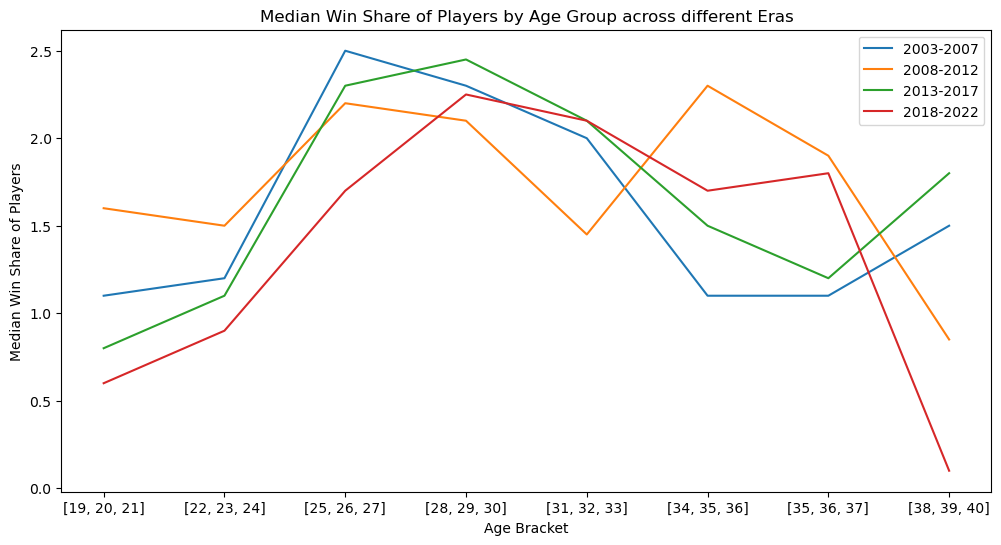

In [607]:
# Define column of interest for y-axis
column_of_interest = 'Median Win Share of Players'

plt.figure(figsize=(12,6))

# Plot Era 1
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2003, 2004, 2005, 2006, 2007]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2003-2007")

# Plot 2
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2008, 2009, 2010, 2011, 2012]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2008-2012")

# Plot 3
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2013, 2014, 2015, 2016, 2017]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2013-2017")

# Plot Era 4
subset_df1 = age_performance_in_different_eras_df.loc[age_performance_in_different_eras_df['Era']=='[2018, 2019, 2020, 2021, 2022]']

x = subset_df1['Age Bracket']
y = subset_df1[column_of_interest]

plt.plot(x,y, label = "2018-2022")

# Display
plt.xlabel("Age Bracket")
plt.ylabel(column_of_interest)
plt.title(f'{column_of_interest} by Age Group across different Eras')

plt.legend() 
plt.show()